# Bengali.AI SEResNeXt training with pytorch

I will introduce following contents

 - **Fast data loading** with feather format
 - **Data augmentation** technic with affine transformation
 - **CNN SoTA models**: Use pytorch `pretrainedmodels` library, especially I use **`SEResNeXt`** in this notebook
 - **Training code abstraction**: Use `pytorch-ignite` module for the trainining abstraction
 
### Update history

 - 2020/1/4 v2: Added albumentations augmentations introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)

# Table of Contents:
**[Fast data loading with feather](#load)**<br>
**[Dataset](#dataset)**<br>
**[Data augmentation/processing](#processing)**<br>
**[pytorch model & define classifier](#model)**<br>
**[Training code](#train)**<br>
**[Prediction](#pred)**<br>
**[Reference and further reading](#ref)**<br>

To install https://github.com/Cadene/pretrained-models.pytorch without internet connection, we can install library as "dataset".

It is uploaded by @rishabhiitbhu : https://www.kaggle.com/rishabhiitbhu/pretrainedmodels

In [1]:
!pip install ../input/pretrainedmodels/pretrainedmodels-0.7.4/ > /dev/null # no output

    ERROR: Command errored out with exit status 1:
     command: /home/dohee/anaconda3/bin/python -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-req-build-wae1wdl0/setup.py'"'"'; __file__='"'"'/tmp/pip-req-build-wae1wdl0/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /tmp/pip-req-build-wae1wdl0/pip-egg-info
         cwd: /tmp/pip-req-build-wae1wdl0/
    Complete output (7 lines):
    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "/tmp/pip-req-build-wae1wdl0/setup.py", line 25, in <module>
        exec(open('pretrainedmodels/version.py').read())
      File "/home/dohee/anaconda3/lib/python3.7/codecs.py", line 904, in open
        file = builtins.open(filename, mode, buffering)
    FileNotFoundError: [Errno 2] No such file or directory: 'pretrainedmodels/version.py'
    -----------

In [62]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
# import lightgbm as lgb
# import xgboost as xgb
# import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

In [63]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../input/pretrainedmodels.zip
../input/bengaliaicv19feather/test_image_data_2.feather
../input/bengaliaicv19feather/train_image_data_0.feather
../input/bengaliaicv19feather/test_image_data_3.feather
../input/bengaliaicv19feather/train_image_data_2.feather
../input/bengaliaicv19feather/train_image_data_3.feather
../input/bengaliaicv19feather/test_image_data_0.feather
../input/bengaliaicv19feather/test_image_data_1.feather
../input/bengaliaicv19feather/train_image_data_1.feather
../input/pretrainedmodels/pretrainedmodels-0.7.4/setup.cfg
../input/pretrainedmodels/pretrainedmodels-0.7.4/setup.py
../input/pretrainedmodels/pretrainedmodels-0.7.4/PKG-INFO
../input/pretrainedmodels/pretrainedmodels-0.7.4/README.md
../input/pretrainedmodels/pretrainedmodels-0.7.4/pretrainedmodels.egg-info/PKG-INFO
../input/pretrainedmodels/pretrainedmodels-0.7.4/pretrainedmodels.egg-info/SOURCES.txt
../input/pretrainedmodels/pretrainedmodels-0.7.4/pretrainedmodels.egg-info/requires.txt
../input/pretrainedmodels

In [64]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load in 

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the "../input/" directory.
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # Any results you write to the current directory are saved as output.

In [65]:
debug=False
submission=False
batch_size=32*4
device='cuda:0'
out='.'
image_size=64*2
arch='pretrained'
model_name='densenet121'

In [66]:
import json

data = {
    "image_size": image_size,
    "threshold": 20.0,
    "arch": "pretrained",
    "model_name": model_name
}

In [67]:
with open(r'./save/args.json', 'w') as f:
    json.dump(data, f, indent=4)

In [68]:
datadir = Path('../input/bengaliai-cv19')
featherdir = Path('../input/bengaliaicv19feather')
outdir = Path('./save')

In [9]:
# Read in the data CSV files
# train = pd.read_csv(datadir/'train.csv')
# test = pd.read_csv(datadir/'test.csv')
# sample_submission = pd.read_csv(datadir/'sample_submission.csv')
# class_map = pd.read_csv(datadir/'class_map.csv')

# Fast data loading with feather

Refer [Bengali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bengali-ai-super-fast-data-loading-with-feather) and [dataset](https://www.kaggle.com/corochann/bengaliaicv19feather) for detail.<br/>
Original `parquet` format takes about 60 sec to load 1 data, while `feather` format takes about **2 sec to load 1 data!!!**

### How to add dataset

When you write kernel, click "+ Add Data" botton on right top.<br/>
Then inside window pop-up, you can see "Search Datasets" text box on right top.<br/>
You can type "bengaliai-cv19-feather" to find this dataset and press "Add" botton to add the data.

In [69]:
import numpy as np
import pandas as pd
import gc


def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    HEIGHT = 137
    WIDTH = 236
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH) for df in image_df_list]
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images


In [11]:
%%time

train = pd.read_csv(datadir/'train.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0] if debug else [0, 1, 2, 3]
train_images = prepare_image(
    datadir, featherdir, data_type='train', submission=False, indices=indices)


image_df_list 4
CPU times: user 19.9 s, sys: 20.9 s, total: 40.8 s
Wall time: 8.71 s


<a id="dataset"></a>
# Dataset

In [70]:
"""
Referenced `chainer.dataset.DatasetMixin` to work with pytorch Dataset.
"""
import numpy
import six
import torch
from torch.utils.data.dataset import Dataset


class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError


This `DatasetMixin` class can be used to define any custom dataset class in pytorch. We can implement `get_example(self, i)` method to return `i`-th data.

Here I return i-th image `x` and `label`, with scaling image to be value ranges between 0~1.

In [71]:
import numpy as np
import cv2

class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        
        
        #x = x.astype(np.float32) / 255.
        #x = x.astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_GRAY2BGR)
        x = x.astype(np.double)
        
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x


Let's see how this `BengaliAIDataset` work

`train_dataset[i]` returns i-th image array and 3 target labels (graphme_root, vowel_diacritic and consonant_diacritic).

In [23]:
train_dataset = BengaliAIDataset(train_images, train_labels)

image, label = train_dataset[0]
print('image', image.shape, 'label', label)

image (137, 236, 3) label [15  9  5]


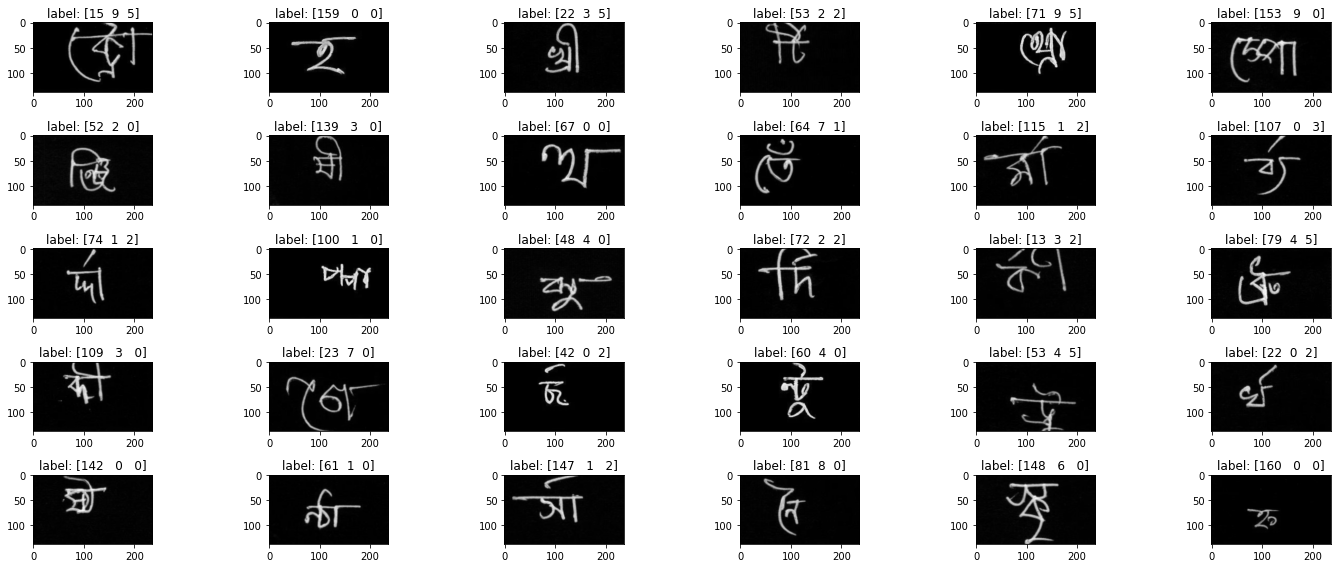

<Figure size 432x288 with 0 Axes>

In [24]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()
plt.savefig('bengaliai.png')

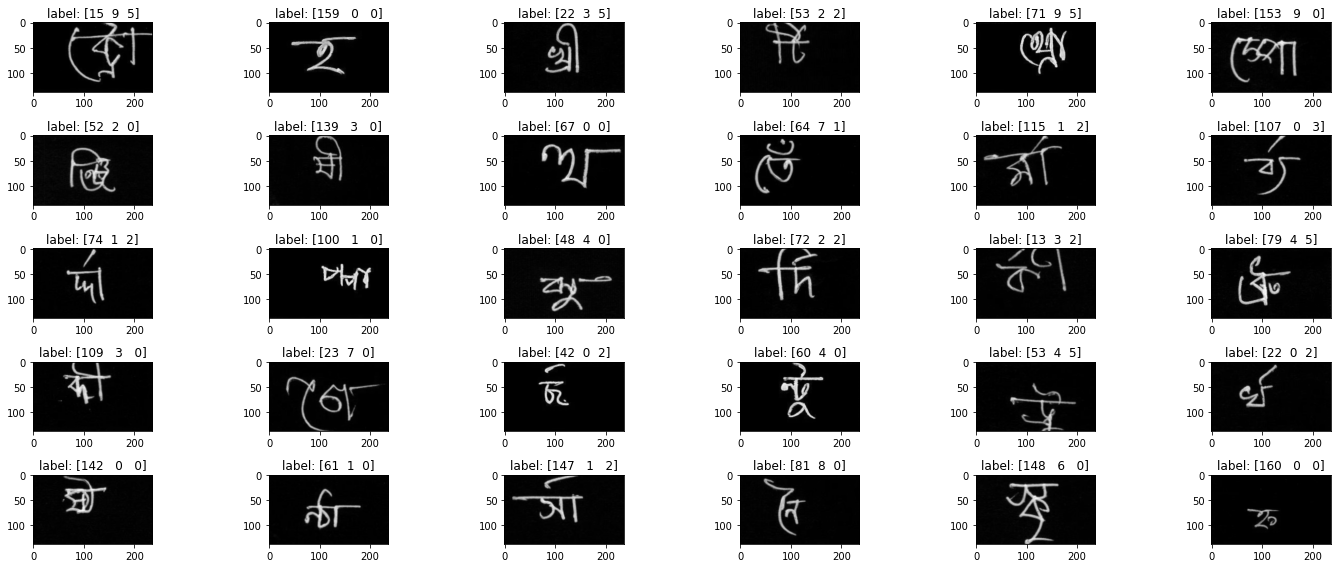

<Figure size 432x288 with 0 Axes>

In [25]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()
plt.savefig('bengaliai.png')

<a id="processing"></a>
# Data augmentation/processing

For CNN training, data augmentation is important to improve test accuracy (generalization performance). I will show some image preprocessing to increase the data variety.

In [72]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import AffineTransform, warp
import numpy as np


def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    # ch, h, w = img.shape
    # img = img / 255.
    #if img.ndim == 3:
    #    img = img[0]

    # --- scale ---
    min_scale = 0.8
    max_scale = 1.2
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 15 #7
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle) * np.pi / 180.

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle) * np.pi / 180.

    # --- translation ---
    max_translation = 4
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)

    tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle,
                            translation=(tx, ty))
    transformed_image = warp(img, tform)
    #assert transformed_image.ndim == 2
    return transformed_image


from scipy.ndimage.measurements import label

def connected_comp(array):
    
    structure = np.ones((3, 3), dtype=np.int)  # this defines the connection filter
    labeled, ncomponents = label(array, structure)
    
    valid = []
    for i in range(1,ncomponents+1):
        if np.sum(labeled == i)>10:
            valid.append(i)

    new_array = np.zeros(array.shape)
    for i in valid:
        new_array += labeled==i
    return new_array

def crop_char_image(image, threshold=5./255.):
    #assert image.ndim == 2
    is_black = np.copy(image[:,:,0])
    is_black = is_black > threshold
    is_black[:2,:] = 0
    is_black[-2:,:] = 0
    is_black[:,:2] = 0
    is_black[:,-2:] = 0

    is_black = connected_comp(is_black)

    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    
    left = np.argmax(is_black_horizontal)-2
    right = np.argmax(is_black_horizontal[::-1])+2
    top = np.argmax(is_black_vertical)+2
    bottom = np.argmax(is_black_vertical[::-1])-2
    height, width, _ = image.shape
    cropped_image = image[left:height - right, top:width - bottom, :]
    return cropped_image


def resize(image, size=(128, 128)):
    return cv2.resize(image, size)

## Affine transformation for data augmentation

To increase validation score, the number of training data is important. When we can use more number of training data, we can reduce overfitting and validation score becomes high.

"Data augmentation" is a technic to virtually create extra training data, based on the given training data. For this MNIST task, data augmentation can be achieved by utilizing affine transformation.

1. Rotation AffineTransformation
2. Translation
3. Scale
4. Shear

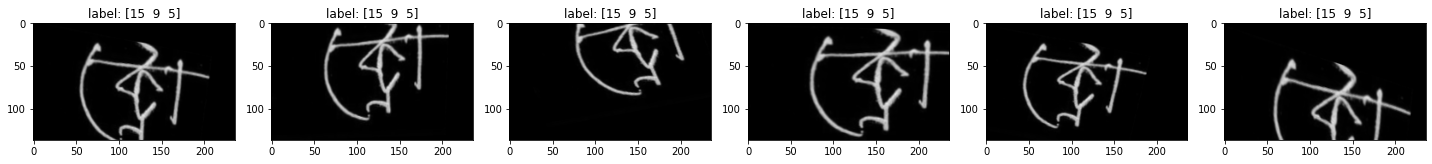

In [27]:
nrow, ncol = 1, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label2 = train_dataset[0]
    ax.imshow(affine_image(image), cmap='Greys')
    ax.set_title(f'label: {label2}')
plt.tight_layout()

When the image is slightly rotated, shifted (transformed) or scaled, the image looks like the same label. We can virtually create another image data from one image in such a way.

## crop image

Here I crop image

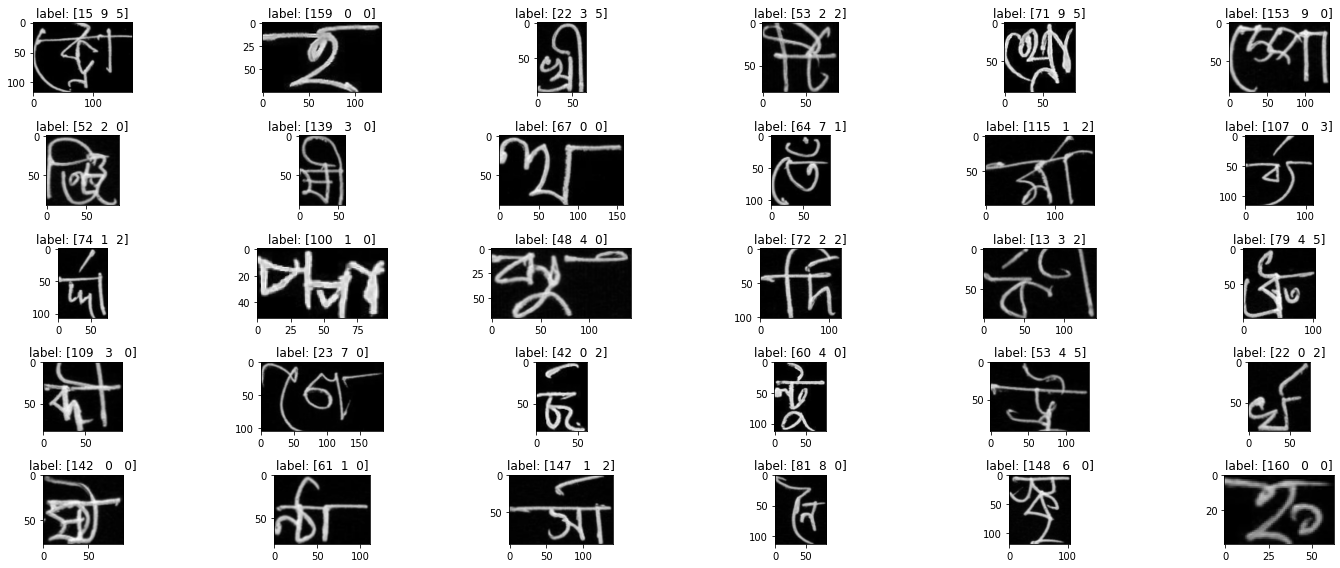

In [28]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label2 = train_dataset[i]
    ax.imshow(crop_char_image(image, threshold=20./255.), cmap='Greys')
    ax.set_title(f'label: {label2}')
plt.tight_layout()

In [29]:
train_dataset[6][0].shape

(137, 236, 3)

## resize image

We need to resize image after crop, to align image size for CNN batch training.

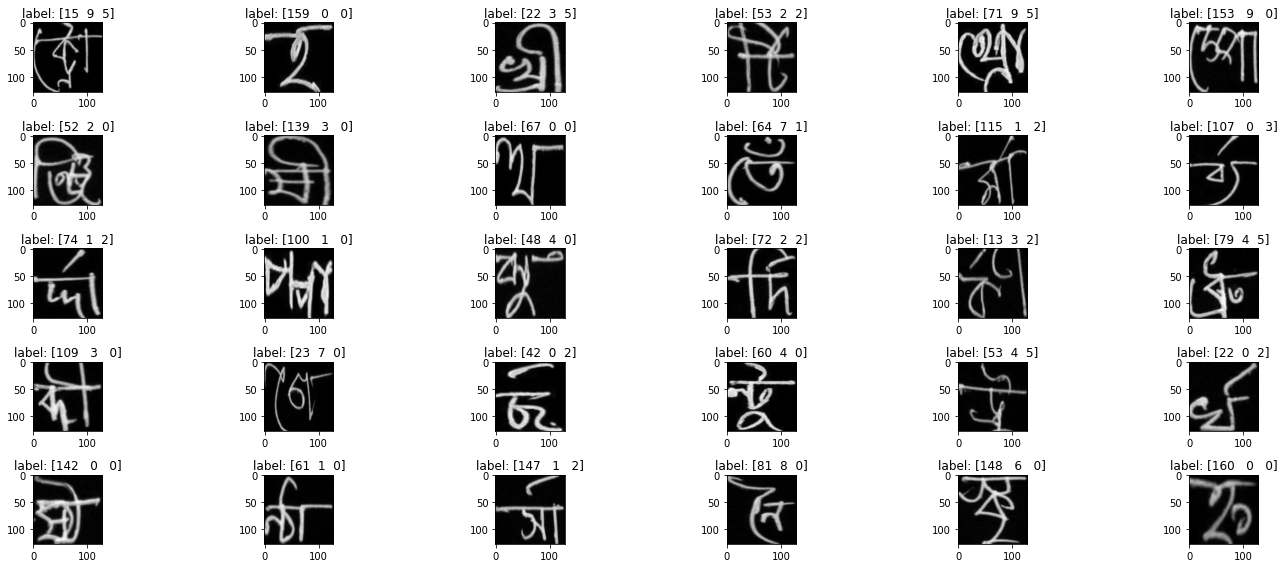

In [30]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label2 = train_dataset[i]
    ax.imshow(resize(crop_char_image(image, threshold=20./255.)), cmap='Greys')
    ax.set_title(f'label: {label2}')
plt.tight_layout()

Put everything together with `Transform` class. <br>
[Update] I added **albumentations augmentations** introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial).

In [73]:
import albumentations as A
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


def _evaluate_ratio(ratio):
    if ratio <= 0.:
        return False
    return np.random.uniform() < ratio


def apply_aug(aug, image):
    return aug(image=image)['image']


class Transform:
    def __init__(self, affine=True, crop=True, size=(64, 64),
                 normalize=True, train=True, threshold=40.,
                 sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
                 grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
                 piece_affine_ratio=0., ssr_ratio=0.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

        self.blur_ratio = blur_ratio
        self.noise_ratio = noise_ratio
        self.cutout_ratio = cutout_ratio
        self.grid_distortion_ratio = grid_distortion_ratio
        self.elastic_distortion_ratio = elastic_distortion_ratio
        self.random_brightness_ratio = random_brightness_ratio
        self.piece_affine_ratio = piece_affine_ratio
        self.ssr_ratio = ssr_ratio

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)

        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
        if self.size is not None:
            try:
                x = resize(x, size=self.size)
            except:
                print("resize error")
                x, y = example
                x = resize(x, size=self.size)
        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)

        # albumentations...
        x = x.astype(np.double)
        #assert x.ndim == 2
        # 1. blur
        if _evaluate_ratio(self.blur_ratio):
            r = np.random.uniform()
            if r < 0.25:
                x = apply_aug(A.Blur(p=1.0), x)
            elif r < 0.5:
                x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
            elif r < 0.75:
                x = apply_aug(A.GaussianBlur(p=1.0), x)
            else:
                x = apply_aug(A.MotionBlur(p=1.0), x)

        if _evaluate_ratio(self.noise_ratio):
            r = np.random.uniform()
            if r < 0.50:
                x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
            else:
                x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

        if _evaluate_ratio(self.cutout_ratio):
            # A.Cutout(num_holes=2,  max_h_size=2, max_w_size=2, p=1.0)  # Deprecated...
            x = apply_aug(A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=1.0), x)

        if _evaluate_ratio(self.grid_distortion_ratio):
            x = apply_aug(A.GridDistortion(p=1.0), x)

        if _evaluate_ratio(self.elastic_distortion_ratio):
            x = apply_aug(A.ElasticTransform(
                sigma=50, alpha=1, alpha_affine=10, p=1.0), x)

        if _evaluate_ratio(self.random_brightness_ratio):
            # A.RandomBrightness(p=1.0)  # Deprecated...
            # A.RandomContrast(p=1.0)    # Deprecated...
            x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

        if _evaluate_ratio(self.piece_affine_ratio):
            x = apply_aug(A.IAAPiecewiseAffine(p=1.0), x)

        if _evaluate_ratio(self.ssr_ratio):
            x = apply_aug(A.ShiftScaleRotate(
                shift_limit=0.0625,
                scale_limit=0.1,
                rotate_limit=30,
                p=1.0), x)

        if self.normalize:
            x = (x.astype(np.double) - 0.0692) / 0.2051
            
            
        #if x.ndim == 2:
        #    x = x[None, :, :]
        x = np.einsum('ijk->kij', x)
        
        x = x.astype(np.double)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x
        
# class Transform:
#     def __init__(self, affine=True, crop=True, size=(64, 64),
#                  normalize=True, train=True, threshold=40.,
#                  sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
#                  grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
#                  piece_affine_ratio=0., ssr_ratio=0.):
#         self.affine = affine
#         self.crop = crop
#         self.size = size
#         self.normalize = normalize
#         self.train = train
#         self.threshold = threshold / 255.
#         self.sigma = sigma / 255.

#         self.blur_ratio = blur_ratio
#         self.noise_ratio = noise_ratio
#         self.cutout_ratio = cutout_ratio
#         self.grid_distortion_ratio = grid_distortion_ratio
#         self.elastic_distortion_ratio = elastic_distortion_ratio
#         self.random_brightness_ratio = random_brightness_ratio
#         self.piece_affine_ratio = piece_affine_ratio
#         self.ssr_ratio = ssr_ratio

#     def __call__(self, example):
#         if self.train:
#             x, y = example
#         else:
#             x = example
#         # --- Augmentation ---
#         if self.affine:
#             x = affine_image(x)

#         # --- Train/Test common preprocessing ---
#         if self.crop:
#             x = crop_char_image(x, threshold=self.threshold)
#         if self.size is not None:
#             x = resize(x, size=self.size)
#         if self.sigma > 0.:
#             x = add_gaussian_noise(x, sigma=self.sigma)

#         # albumentations...
#         x = x.astype(np.float32)
#         assert x.ndim == 2
#         # 1. blur
#         if _evaluate_ratio(self.blur_ratio):
#             r = np.random.uniform()
#             if r < 0.25:
#                 x = apply_aug(A.Blur(p=1.0), x)
#             elif r < 0.5:
#                 x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
#             elif r < 0.75:
#                 x = apply_aug(A.GaussianBlur(p=1.0), x)
#             else:
#                 x = apply_aug(A.MotionBlur(p=1.0), x)

#         if _evaluate_ratio(self.noise_ratio):
#             r = np.random.uniform()
#             if r < 0.50:
#                 x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
#             else:
#                 x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

#         if _evaluate_ratio(self.cutout_ratio):
#             # A.Cutout(num_holes=2,  max_h_size=2, max_w_size=2, p=1.0)  # Deprecated...
#             x = apply_aug(A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=1.0), x)

#         if _evaluate_ratio(self.grid_distortion_ratio):
#             x = apply_aug(A.GridDistortion(p=1.0), x)

#         if _evaluate_ratio(self.elastic_distortion_ratio):
#             x = apply_aug(A.ElasticTransform(
#                 sigma=50, alpha=1, alpha_affine=10, p=1.0), x)

#         if _evaluate_ratio(self.random_brightness_ratio):
#             # A.RandomBrightness(p=1.0)  # Deprecated...
#             # A.RandomContrast(p=1.0)    # Deprecated...
#             x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

#         if _evaluate_ratio(self.piece_affine_ratio):
#             x = apply_aug(A.IAAPiecewiseAffine(p=1.0), x)

#         if _evaluate_ratio(self.ssr_ratio):
#             x = apply_aug(A.ShiftScaleRotate(
#                 shift_limit=0.0625,
#                 scale_limit=0.1,
#                 rotate_limit=30,
#                 p=1.0), x)

#         if self.normalize:
#             x = (x.astype(np.float32) - 0.0692) / 0.2051
#         if x.ndim == 2:
#             x = x[None, :, :]
#         x = x.astype(np.float32)
#         if self.train:
#             y = y.astype(np.int64)
#             return x, y
#         else:
#             return x
        

In [74]:
train_transform = Transform(
    size=(image_size, image_size), threshold=20.,
    sigma=-1., blur_ratio=0.2, noise_ratio=0.2, cutout_ratio=0.2,
    grid_distortion_ratio=0.2, random_brightness_ratio=0.2,
    piece_affine_ratio=0.2, ssr_ratio=0.2)
# transform = Transform(size=(image_size, image_size)
train_dataset = BengaliAIDataset(train_images, train_labels,
                                 transform=train_transform)

By setting `transform`, its function is called **every time** when we access to the index. Dataset returns different `image` every time! which is useful for training with data augmentation.

In [33]:
# nrow, ncol = 1, 6

# fig, axes = plt.subplots(nrow, ncol, figsize=(20, 2))
# axes = axes.flatten()
# for i, ax in tqdm(enumerate(axes)):
#     image, label = train_dataset[0]
#     ax.imshow(image[0], cmap='Greys')
#     ax.set_title(f'label: {label}')
# plt.tight_layout()

Let's final check the processed images, which will be trained by the model.

In [34]:
# nrow, ncol = 5, 6

# fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
# axes = axes.flatten()
# for i, ax in tqdm(enumerate(axes)):
#     image, label = train_dataset[i]
#     ax.imshow(image[0], cmap='Greys')
#     ax.set_title(f'label: {label}')
# plt.tight_layout()

<a id="model"></a> 
# pytorch model & define classifier

In [75]:
import torch


def residual_add(lhs, rhs):
    lhs_ch, rhs_ch = lhs.shape[1], rhs.shape[1]
    if lhs_ch < rhs_ch:
        out = lhs + rhs[:, :lhs_ch]
    elif lhs_ch > rhs_ch:
        out = torch.cat([lhs[:, :rhs_ch] + rhs, lhs[:, rhs_ch:]], dim=1)
    else:
        out = lhs + rhs
    return out


In [76]:
from typing import List

import torch
from torch import nn
from torch.nn.parameter import Parameter


class LazyLoadModule(nn.Module):
    """Lazy buffer/parameter loading using load_state_dict_pre_hook

    Define all buffer/parameter in `_lazy_buffer_keys`/`_lazy_parameter_keys` and
    save buffer with `register_buffer`/`register_parameter`
    method, which can be outside of __init__ method.
    Then this module can load any shape of Tensor during de-serializing.

    Note that default value of lazy buffer is torch.Tensor([]), while lazy parameter is None.
    """
    _lazy_buffer_keys: List[str] = []     # It needs to be override to register lazy buffer
    _lazy_parameter_keys: List[str] = []  # It needs to be override to register lazy parameter

    def __init__(self):
        super(LazyLoadModule, self).__init__()
        for k in self._lazy_buffer_keys:
            self.register_buffer(k, torch.tensor([]))
        for k in self._lazy_parameter_keys:
            self.register_parameter(k, None)
        self._register_load_state_dict_pre_hook(self._hook)

    def _hook(self, state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs):
        for key in self._lazy_buffer_keys:
            self.register_buffer(key, state_dict[prefix + key])

        for key in self._lazy_parameter_keys:
            self.register_parameter(key, Parameter(state_dict[prefix + key]))


In [77]:
import math
import torch
from torch.nn import init
from torch.nn.parameter import Parameter
import torch.nn.functional as F


class LazyLinear(LazyLoadModule):
    """Linear module with lazy input inference

    `in_features` can be `None`, and it is determined at the first time of forward step dynamically.
    """

    __constants__ = ['bias', 'in_features', 'out_features']
    _lazy_parameter_keys = ['weight']

    def __init__(self, in_features, out_features, bias=True):
        super(LazyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        if in_features is not None:
            self.weight = Parameter(torch.Tensor(out_features, in_features))
            self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.weight is None:
            self.in_features = input.shape[-1]
            self.weight = Parameter(torch.Tensor(self.out_features, self.in_features))
            self.reset_parameters()

            # Need to send lazy defined parameter to device...
            self.to(input.device)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [78]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [99]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential


class PretrainedCNN(nn.Module):
    def __init__(self, model_name='densenet121',
                 in_channels=1, out_dim=10, use_bn=True,
                 pretrained='imagenet'):
        super(PretrainedCNN, self).__init__()
        self.conv0 = nn.Conv2d(
            in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
        self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
        activation = F.leaky_relu
        self.do_pooling = True
        if self.do_pooling:
            inch = self.base_model.last_linear.in_features
        else:
            inch = None
        hdim = 512
        lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation=None, residual=False)
        self.lin_layers = Sequential(lin1, lin2)

    def forward(self, x):
        
        h = self.conv0(x)
        h = self.base_model.features(h)
        
        if self.do_pooling:
            h = torch.sum(h, dim=(-1, -2))
        else:
            # [128, 2048, 4, 4] when input is (128, 128)
            bs, ch, height, width = h.shape
            h = h.view(bs, ch*height*width)
        for layer in self.lin_layers:
            h = layer(h)
            
        return h

## Classifier

In [80]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2
def cutmix(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    while lam > 0.9997:
        lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    
    
#     print(lam)
#     print(data.shape)
#     print(indices)
#     print(bbx1, bbx2, bby1, bby2)
    
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]
    return data, targets

def mixup(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    data = data * lam + shuffled_data * (1 - lam)
    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]

    return data, targets


def cutmix_criterion(preds1,preds2,preds3, targets):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    return lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2) + lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4) + lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)

def mixup_criterion(preds1,preds2,preds3, targets):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    return lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2) + lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4) + lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)

In [81]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.double)
    acc = correct / count
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor.float()
        
        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']
        
    def forward(self, x, y=None):
        
        const = np.random.randint(6)
        
        if const<2:        
            # mixup
            data, targets = mixup(x, y[:,0], y[:,1], y[:,2], 0.4)
            x = data

        elif const<4:        
            # cutmix
            data, targets = cutmix(x, y[:,0], y[:,1], y[:,2], 0.4)
            x = data

            
            
        pred = self.predictor(x)
        
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        
        if const<4:
            # cutmix or mixup
            targets1, targets2, targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]        
            preds1, preds2, preds3 = preds[0], preds[1], preds[2]
            lam = float(lam)
            loss_grapheme = lam * F.cross_entropy(preds1, targets1) + (1 - lam) * F.cross_entropy(preds1, targets2) 
            loss_vowel = lam * F.cross_entropy(preds2, targets3) + (1 - lam) * F.cross_entropy(preds2, targets4)
            loss_consonant = lam * F.cross_entropy(preds3, targets5) + (1 - lam) * F.cross_entropy(preds3, targets6)
            loss = loss_grapheme + loss_vowel + loss_consonant  
        else:
            loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
            loss_vowel = F.cross_entropy(preds[1], y[:, 1])
            loss_consonant = F.cross_entropy(preds[2], y[:, 2])
            loss = loss_grapheme + loss_vowel + loss_consonant
            
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        
        return loss, metrics, pred
    
    
    
    def forward_val(self, x, y=None):

        pred = self.predictor(x)
        
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        
        loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = F.cross_entropy(preds[2], y[:, 2])
        loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        
        return loss, metrics, pred
    

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                
                
                
                pred = self.predictor(batch)
                
                
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels

In [42]:
# import torch
# from torch import nn
# import torch.nn.functional as F
# from tqdm import tqdm


# def accuracy(y, t):
#     pred_label = torch.argmax(y, dim=1)
#     count = pred_label.shape[0]
#     correct = (pred_label == t).sum().type(torch.double)
#     acc = correct / count
#     return acc


# class BengaliClassifier(nn.Module):
#     def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
#         super(BengaliClassifier, self).__init__()
#         self.n_grapheme = n_grapheme
#         self.n_vowel = n_vowel
#         self.n_consonant = n_consonant
#         self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
#         self.predictor = predictor.float()
        
#         self.metrics_keys = [
#             'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
#             'acc_grapheme', 'acc_vowel', 'acc_consonant']

#     def forward(self, x, y=None):
#         const = np.random.rand()
#         if const<0.4:        
#             # mixup
#             data, targets = mixup(x, y[:,0], y[:,1], y[:,2], 0.4)
#             x = data
#         elif const<0.8:
#             # cutmix
#             data, targets = cutmix(x, y[:,0], y[:,1], y[:,2], 0.4)
#             x = data
#         pred = self.predictor(x)
        
        
#         if isinstance(pred, tuple):
#             assert len(pred) == 3
#             preds = pred
#         else:
#             assert pred.shape[1] == self.n_total_class
#             preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        
#         if const<0.8:
#             # cutmix or mixup
#             targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]        
#             preds1, preds2, preds3 = preds[0], preds[1], preds[2]
#             #loss_grapheme = lam * F.cross_entropy(preds1, targets1) + (1 - lam) * F.cross_entropy(preds1, targets2) 
#             #loss_vowel = lam * F.cross_entropy(preds2, targets3) + (1 - lam) * F.cross_entropy(preds2, targets4)
#             #loss_consonant = lam * F.cross_entropy(preds3, targets5) + (1 - lam) * F.cross_entropy(preds3, targets6)
            
            
#             #criterion = nn.CrossEntropyLoss()
#             #loss_grapheme = lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2) 
#             #loss_vowel = lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4)
#             #loss_consonant = lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)
            
            
#             loss = loss_grapheme + loss_vowel + loss_consonant  
            
            
            
            
#         else:
#             loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
#             loss_vowel = F.cross_entropy(preds[1], y[:, 1])
#             loss_consonant = F.cross_entropy(preds[2], y[:, 2])
#             loss = loss_grapheme + loss_vowel + loss_consonant
            
#         metrics = {
#             'loss': loss.item(),
#             'loss_grapheme': loss_grapheme.item(),
#             'loss_vowel': loss_vowel.item(),
#             'loss_consonant': loss_consonant.item(),
#             'acc_grapheme': accuracy(preds[0], y[:, 0]),
#             'acc_vowel': accuracy(preds[1], y[:, 1]),
#             'acc_consonant': accuracy(preds[2], y[:, 2]),
#         }
        
#         return loss, metrics, pred
    
    
    
#     def forward_val(self, x, y=None):

#         pred = self.predictor(x)
        
#         if isinstance(pred, tuple):
#             assert len(pred) == 3
#             preds = pred
#         else:
#             assert pred.shape[1] == self.n_total_class
#             preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        
#         loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
#         loss_vowel = F.cross_entropy(preds[1], y[:, 1])
#         loss_consonant = F.cross_entropy(preds[2], y[:, 2])
#         loss = loss_grapheme + loss_vowel + loss_consonant
#         metrics = {
#             'loss': loss.item(),
#             'loss_grapheme': loss_grapheme.item(),
#             'loss_vowel': loss_vowel.item(),
#             'loss_consonant': loss_consonant.item(),
#             'acc_grapheme': accuracy(preds[0], y[:, 0]),
#             'acc_vowel': accuracy(preds[1], y[:, 1]),
#             'acc_consonant': accuracy(preds[2], y[:, 2]),
#         }
        
#         return loss, metrics, pred
    

#     def calc(self, data_loader):
#         device: torch.device = next(self.parameters()).device
#         self.eval()
#         output_list = []
#         with torch.no_grad():
#             for batch in tqdm(data_loader):
#                 # TODO: support general preprocessing.
#                 # If `data` is not `Data` instance, `to` method is not supported!
#                 batch = batch.to(device)
                
                
                
#                 pred = self.predictor(batch)
                
                
#                 output_list.append(pred)
#         output = torch.cat(output_list, dim=0)
#         preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
#         return preds

#     def predict_proba(self, data_loader):
#         preds = self.calc(data_loader)
#         return [F.softmax(p, dim=1) for p in preds]

#     def predict(self, data_loader):
#         preds = self.calc(data_loader)
#         pred_labels = [torch.argmax(p, dim=1) for p in preds]
#         return pred_labels


<a id="train"></a>
# Training code

## prepare data

In [43]:
n_dataset = len(train_images)
train_data_size = 200 if debug else int(n_dataset * 0.9)
valid_data_size = 100 if debug else int(n_dataset - train_data_size)

perm = np.random.RandomState(777).permutation(n_dataset)
print('perm', perm)
train_dataset = BengaliAIDataset(
    train_images, train_labels, transform=Transform(size=(image_size, image_size)),
    indices=perm[:train_data_size])
valid_dataset = BengaliAIDataset(
    train_images, train_labels, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
    indices=perm[train_data_size:train_data_size+valid_data_size])
print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))

# --- Model ---
device = torch.device(device)
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)
# Set pretrained='imagenet' to download imagenet pretrained model...

predictor = PretrainedCNN(in_channels=3, out_dim=n_total, model_name=model_name, pretrained=None)
#predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained=None)
print('predictor', type(predictor))

classifier = BengaliClassifier(predictor).to(device)


perm [ 95762  34576  11800 ... 183206 113455  63591]
train_dataset 180756 valid_dataset 20084
n_total 186
predictor <class '__main__.PretrainedCNN'>


/home/dohee/anaconda3/envs/CenterNet/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning:

nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.



In [44]:
predictor

PretrainedCNN(
  (conv0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (base_model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _D

## Ignite utility

pytorch-ignite utility class for training

In [82]:
import json
from logging import getLogger
import numpy

def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

import os
from logging import getLogger
from time import perf_counter

import pandas as pd
import torch
# from chainer_chemistry.utils import save_json

from ignite.engine.engine import Engine, Events
from ignite.metrics import Average


class DictOutputTransform:
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]


def create_trainer(classifier, optimizer, device):
    classifier.to(device)    
    def update_fn(engine, batch):
        classifier.train()
        optimizer.zero_grad()

        # batch = [elem.to(device) for elem in batch]
        x, y = [elem.to(device) for elem in batch]
        x = x.float()
        
#         # mixup
#         data, targets = mixup(x, y[:,0], y[:,1], y[:,2], 0.4)
#         #print(data.shape)
#         print(len(targets))
#         print(targets[0].shape)
#         print(y.shape)
        
#         print(targets)
#         print(y)

        
        loss, metrics, pred_y = classifier(x, y)
        
#         print(pred_y.shape)
#         print(pred_y)
#         print("---------------")
        
        loss.backward()
        optimizer.step()
        return metrics, pred_y, y
    
    
    trainer = Engine(update_fn)
    
    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(trainer, key)
        
    return trainer


def create_evaluator(classifier, device):
    classifier.to(device)
    def update_fn(engine, batch):
        classifier.eval()
        with torch.no_grad():
            # batch = [elem.to(device) for elem in batch]
            x, y = [elem.to(device) for elem in batch]
            x = x.float()
            _, metrics, pred_y = classifier.forward_val(x, y)
            return metrics, pred_y, y
    evaluator = Engine(update_fn)
    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(evaluator, key)
    return evaluator


class LogReport:
    def __init__(self, evaluator=None, dirpath=None, logger=None):
        self.evaluator = evaluator
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        self.reported_dict[key] = value

    def __call__(self, engine):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': engine.state.epoch,
                'iteration': engine.state.iteration}
        elem.update({f'train/{key}': value
                     for key, value in engine.state.metrics.items()})
        if self.evaluator is not None:
            elem.update({f'valid/{key}': value
                         for key, value in self.evaluator.state.metrics.items()})
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath, 'log.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath, 'log.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df


class SpeedCheckHandler:
    def __init__(self, iteration_interval=10, logger=None):
        self.iteration_interval = iteration_interval
        self.logger = logger or getLogger(__name__)
        self.prev_time = perf_counter()

    def __call__(self, engine: Engine):
        if engine.state.iteration % self.iteration_interval == 0:
            cur_time = perf_counter()
            spd = self.iteration_interval / (cur_time - self.prev_time)
            self.logger.warning(f'{spd} iter/sec')
            # reset
            self.prev_time = cur_time

    def attach(self, engine: Engine):
        engine.add_event_handler(Events.ITERATION_COMPLETED, self)


class ModelSnapshotHandler:
    def __init__(self, model, filepath=r'./save/model_{count:06}.pt',
                 interval=10, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self, engine: Engine):
        self.count += 1
        if self.count % self.interval == 0:
            filepath = self.filepath.format(count=self.count)
            torch.save(self.model.state_dict(), filepath)
            # self.logger.warning(f'save model to {filepath}...')


import warnings

import torch

from ignite.metrics.metric import Metric


class EpochMetric(Metric):
    """Class for metrics that should be computed on the entire output history of a model.
    Model's output and targets are restricted to be of shape `(batch_size, n_classes)`. Output
    datatype should be `float32`. Target datatype should be `long`.

    .. warning::

        Current implementation stores all input data (output and target) in as tensors before computing a metric.
        This can potentially lead to a memory error if the input data is larger than available RAM.


    - `update` must receive output of the form `(y_pred, y)`.

    If target shape is `(batch_size, n_classes)` and `n_classes > 1` than it should be binary: e.g. `[[0, 1, 0, 1], ]`.

    Args:
        compute_fn (callable): a callable with the signature (`torch.tensor`, `torch.tensor`) takes as the input
            `predictions` and `targets` and returns a scalar.
        output_transform (callable, optional): a callable that is used to transform the
            :class:`~ignite.engine.Engine`'s `process_function`'s output into the
            form expected by the metric. This can be useful if, for example, you have a multi-output model and
            you want to compute the metric with respect to one of the outputs.

    """

    def __init__(self, compute_fn, output_transform=lambda x: x):

        if not callable(compute_fn):
            raise TypeError("Argument compute_fn should be callable.")

        super(EpochMetric, self).__init__(output_transform=output_transform)
        self.compute_fn = compute_fn

    def reset(self):
        self._predictions = torch.tensor([], dtype=torch.float)
        self._targets = torch.tensor([], dtype=torch.long)

    def update(self, output):
        y_pred, y = output
        self._predictions = torch.cat([self._predictions, y_pred], dim=0)
        self._targets = torch.cat([self._targets, y], dim=0)

        # Check once the signature and execution of compute_fn
        if self._predictions.shape == y_pred.shape:
            try:
                self.compute_fn(self._predictions, self._targets)
            except Exception as e:
                warnings.warn("Probably, there can be a problem with `compute_fn`:\n {}.".format(e),
                              RuntimeWarning)

    def compute(self):
        return self.compute_fn(self._predictions, self._targets)


import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score


In [46]:
# def create_trainer(classifier, optimizer, device):
#     classifier.to(device)    
#     def update_fn(engine, batch):
#         classifier.train()
#         optimizer.zero_grad()

#         # batch = [elem.to(device) for elem in batch]
#         x, y = [elem.to(device) for elem in batch]        
#         x = x.float()
        
#         print(x.shape)
#         print(y.shape)
        
#         loss, metrics, pred_y = classifier(x, y)

In [83]:
import argparse
from distutils.util import strtobool
import os

import torch
from ignite.contrib.handlers import ProgressBar
from ignite.engine import Events
from numpy.random.mtrand import RandomState
from torch.utils.data.dataloader import DataLoader

# --- Training setting ---

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=4, min_lr=1e-10)

trainer = create_trainer(classifier, optimizer, device)
def output_transform(output):
    metric, pred_y, y = output
    return pred_y.cpu(), y.cpu()
EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(trainer, 'recall')

pbar = ProgressBar()
pbar.attach(trainer, metric_names='all')

evaluator = create_evaluator(classifier, device)
EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(evaluator, 'recall')

def run_evaluator(engine):
    evaluator.run(valid_loader)

def schedule_lr(engine):
    # metrics = evaluator.state.metrics
    metrics = engine.state.metrics
    avg_mae = metrics['loss']

    # --- update lr ---
    lr = scheduler.optimizer.param_groups[0]['lr']
    scheduler.step(avg_mae)
    log_report.report('lr', lr)

trainer.add_event_handler(Events.EPOCH_COMPLETED, run_evaluator)
trainer.add_event_handler(Events.EPOCH_COMPLETED, schedule_lr)
log_report = LogReport(evaluator, outdir)
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_report)
trainer.add_event_handler(
    Events.EPOCH_COMPLETED,
    ModelSnapshotHandler(predictor))

In [ ]:
trainer.run(train_loader, max_epochs=100)

/home/dohee/anaconda3/envs/CenterNet/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



epoch      1 train/loss  4.954637 train/loss_grapheme  2.800478 train/loss_vowel  1.148123 train/loss_consonant  1.006036 train/acc_grapheme  0.394034 train/acc_vowel  0.646904 train/acc_consonant  0.726958 train/recall  0.496985 valid/loss  1.331689 valid/loss_grapheme  0.646665 valid/loss_vowel  0.349081 valid/loss_consonant  0.335943 valid/acc_grapheme  0.877102 valid/acc_vowel  0.956831 valid/acc_consonant  0.955139 valid/recall  0.921745 lr  0.001000 elapsed_time  1066.240622 


epoch      2 train/loss  2.980236 train/loss_grapheme  1.650389 train/loss_vowel  0.764981 train/loss_consonant  0.564866 train/acc_grapheme  0.585438 train/acc_vowel  0.724678 train/acc_consonant  0.803157 train/recall  0.660098 valid/loss  0.904835 valid/loss_grapheme  0.464714 valid/loss_vowel  0.234585 valid/loss_consonant  0.205536 valid/acc_grapheme  0.903312 valid/acc_vowel  0.963908 valid/acc_consonant  0.967496 valid/recall  0.924645 lr  0.001000 elapsed_time  2118.561608 


epoch      3 train/loss  2.784257 train/loss_grapheme  1.550730 train/loss_vowel  0.727429 train/loss_consonant  0.506098 train/acc_grapheme  0.588254 train/acc_vowel  0.716633 train/acc_consonant  0.802693 train/recall  0.660603 valid/loss  0.735078 valid/loss_grapheme  0.398329 valid/loss_vowel  0.174471 valid/loss_consonant  0.162278 valid/acc_grapheme  0.915977 valid/acc_vowel  0.976557 valid/acc_consonant  0.972909 valid/recall  0.950362 lr  0.001000 elapsed_time  3169.157717 


epoch      4 train/loss  2.509551 train/loss_grapheme  1.399261 train/loss_vowel  0.660038 train/loss_consonant  0.450252 train/acc_grapheme  0.615577 train/acc_vowel  0.732438 train/acc_consonant  0.811295 train/recall  0.684048 valid/loss  0.674348 valid/loss_grapheme  0.341303 valid/loss_vowel  0.183248 valid/loss_consonant  0.149797 valid/acc_grapheme  0.931731 valid/acc_vowel  0.977448 valid/acc_consonant  0.976851 valid/recall  0.946913 lr  0.001000 elapsed_time  4221.493417 


epoch      5 train/loss  2.439769 train/loss_grapheme  1.366612 train/loss_vowel  0.640776 train/loss_consonant  0.432381 train/acc_grapheme  0.614246 train/acc_vowel  0.727226 train/acc_consonant  0.809083 train/recall  0.680766 valid/loss  0.532668 valid/loss_grapheme  0.271907 valid/loss_vowel  0.129155 valid/loss_consonant  0.131606 valid/acc_grapheme  0.937241 valid/acc_vowel  0.978941 valid/acc_consonant  0.977642 valid/recall  0.956734 lr  0.001000 elapsed_time  5273.282055 


epoch      6 train/loss  2.352284 train/loss_grapheme  1.317399 train/loss_vowel  0.618590 train/loss_consonant  0.416295 train/acc_grapheme  0.612677 train/acc_vowel  0.723223 train/acc_consonant  0.807767 train/recall  0.678554 valid/loss  0.475527 valid/loss_grapheme  0.245073 valid/loss_vowel  0.117988 valid/loss_consonant  0.112465 valid/acc_grapheme  0.944878 valid/acc_vowel  0.982374 valid/acc_consonant  0.980185 valid/recall  0.955458 lr  0.001000 elapsed_time  6324.402333 


epoch      7 train/loss  2.280292 train/loss_grapheme  1.275092 train/loss_vowel  0.600596 train/loss_consonant  0.404603 train/acc_grapheme  0.622862 train/acc_vowel  0.730567 train/acc_consonant  0.813136 train/recall  0.688172 valid/loss  0.417954 valid/loss_grapheme  0.224182 valid/loss_vowel  0.102383 valid/loss_consonant  0.091390 valid/acc_grapheme  0.944983 valid/acc_vowel  0.982971 valid/acc_consonant  0.982678 valid/recall  0.959050 lr  0.001000 elapsed_time  7374.752847 


epoch      8 train/loss  2.280352 train/loss_grapheme  1.274271 train/loss_vowel  0.600774 train/loss_consonant  0.405307 train/acc_grapheme  0.630626 train/acc_vowel  0.734480 train/acc_consonant  0.814720 train/recall  0.692217 valid/loss  0.400230 valid/loss_grapheme  0.210150 valid/loss_vowel  0.099249 valid/loss_consonant  0.090831 valid/acc_grapheme  0.948272 valid/acc_vowel  0.984823 valid/acc_consonant  0.982877 valid/recall  0.961043 lr  0.001000 elapsed_time  8425.495181 


epoch      9 train/loss  2.149176 train/loss_grapheme  1.196756 train/loss_vowel  0.564875 train/loss_consonant  0.387546 train/acc_grapheme  0.647294 train/acc_vowel  0.747259 train/acc_consonant  0.823058 train/recall  0.706009 valid/loss  0.380937 valid/loss_grapheme  0.204078 valid/loss_vowel  0.092871 valid/loss_consonant  0.083988 valid/acc_grapheme  0.952711 valid/acc_vowel  0.987206 valid/acc_consonant  0.984475 valid/recall  0.965778 lr  0.001000 elapsed_time  9477.216955 


epoch     10 train/loss  2.088350 train/loss_grapheme  1.161179 train/loss_vowel  0.550476 train/loss_consonant  0.376696 train/acc_grapheme  0.647320 train/acc_vowel  0.742981 train/acc_consonant  0.820473 train/recall  0.703027 valid/loss  0.401625 valid/loss_grapheme  0.209193 valid/loss_vowel  0.106672 valid/loss_consonant  0.085759 valid/acc_grapheme  0.953911 valid/acc_vowel  0.986465 valid/acc_consonant  0.984375 valid/recall  0.966231 lr  0.001000 elapsed_time  10528.499602 


epoch     11 train/loss  2.123669 train/loss_grapheme  1.180211 train/loss_vowel  0.558554 train/loss_consonant  0.384904 train/acc_grapheme  0.639754 train/acc_vowel  0.737147 train/acc_consonant  0.816210 train/recall  0.697215 valid/loss  0.424858 valid/loss_grapheme  0.221537 valid/loss_vowel  0.102962 valid/loss_consonant  0.100359 valid/acc_grapheme  0.953463 valid/acc_vowel  0.986803 valid/acc_consonant  0.983031 valid/recall  0.965116 lr  0.001000 elapsed_time  11573.180300 


epoch     12 train/loss  2.062839 train/loss_grapheme  1.144357 train/loss_vowel  0.544235 train/loss_consonant  0.374247 train/acc_grapheme  0.643069 train/acc_vowel  0.740847 train/acc_consonant  0.818489 train/recall  0.700735 valid/loss  0.345877 valid/loss_grapheme  0.182865 valid/loss_vowel  0.086182 valid/loss_consonant  0.076830 valid/acc_grapheme  0.955145 valid/acc_vowel  0.986813 valid/acc_consonant  0.984674 valid/recall  0.965880 lr  0.001000 elapsed_time  12621.822283 


epoch     13 train/loss  2.013081 train/loss_grapheme  1.114320 train/loss_vowel  0.532565 train/loss_consonant  0.366197 train/acc_grapheme  0.650808 train/acc_vowel  0.744241 train/acc_consonant  0.822661 train/recall  0.704553 valid/loss  0.451747 valid/loss_grapheme  0.230728 valid/loss_vowel  0.127631 valid/loss_consonant  0.093388 valid/acc_grapheme  0.955045 valid/acc_vowel  0.986714 valid/acc_consonant  0.985863 valid/recall  0.966492 lr  0.001000 elapsed_time  13670.775712 


epoch     14 train/loss  1.905132 train/loss_grapheme  1.051059 train/loss_vowel  0.504749 train/loss_consonant  0.349325 train/acc_grapheme  0.670014 train/acc_vowel  0.758733 train/acc_consonant  0.831122 train/recall  0.721589 valid/loss  0.369444 valid/loss_grapheme  0.195487 valid/loss_vowel  0.093360 valid/loss_consonant  0.080597 valid/acc_grapheme  0.955443 valid/acc_vowel  0.987455 valid/acc_consonant  0.984967 valid/recall  0.967149 lr  0.001000 elapsed_time  14718.617636 


epoch     15 train/loss  1.952075 train/loss_grapheme  1.077386 train/loss_vowel  0.515272 train/loss_consonant  0.359417 train/acc_grapheme  0.671977 train/acc_vowel  0.763235 train/acc_consonant  0.833756 train/recall  0.724340 valid/loss  0.414772 valid/loss_grapheme  0.208525 valid/loss_vowel  0.114586 valid/loss_consonant  0.091661 valid/acc_grapheme  0.957887 valid/acc_vowel  0.987311 valid/acc_consonant  0.986714 valid/recall  0.967592 lr  0.001000 elapsed_time  15764.801581 


epoch     16 train/loss  1.809575 train/loss_grapheme  0.994846 train/loss_vowel  0.479871 train/loss_consonant  0.334858 train/acc_grapheme  0.650375 train/acc_vowel  0.738530 train/acc_consonant  0.817894 train/recall  0.698399 valid/loss  0.351218 valid/loss_grapheme  0.173375 valid/loss_vowel  0.094649 valid/loss_consonant  0.083194 valid/acc_grapheme  0.959738 valid/acc_vowel  0.987057 valid/acc_consonant  0.985211 valid/recall  0.967884 lr  0.001000 elapsed_time  16811.407664 


epoch     17 train/loss  1.862323 train/loss_grapheme  1.022455 train/loss_vowel  0.494205 train/loss_consonant  0.345663 train/acc_grapheme  0.673903 train/acc_vowel  0.762236 train/acc_consonant  0.833071 train/recall  0.726053 valid/loss  0.318634 valid/loss_grapheme  0.169408 valid/loss_vowel  0.076621 valid/loss_consonant  0.072604 valid/acc_grapheme  0.960788 valid/acc_vowel  0.987853 valid/acc_consonant  0.987659 valid/recall  0.970548 lr  0.001000 elapsed_time  17859.225387 


epoch     18 train/loss  1.834262 train/loss_grapheme  1.004435 train/loss_vowel  0.489447 train/loss_consonant  0.340380 train/acc_grapheme  0.665122 train/acc_vowel  0.752740 train/acc_consonant  0.827244 train/recall  0.713479 valid/loss  0.288091 valid/loss_grapheme  0.161086 valid/loss_vowel  0.064398 valid/loss_consonant  0.062606 valid/acc_grapheme  0.959688 valid/acc_vowel  0.988848 valid/acc_consonant  0.987803 valid/recall  0.971357 lr  0.001000 elapsed_time  18911.134500 


epoch     19 train/loss  1.758653 train/loss_grapheme  0.962752 train/loss_vowel  0.468048 train/loss_consonant  0.327853 train/acc_grapheme  0.692708 train/acc_vowel  0.777219 train/acc_consonant  0.840908 train/recall  0.741672 valid/loss  0.398811 valid/loss_grapheme  0.202178 valid/loss_vowel  0.110722 valid/loss_consonant  0.085912 valid/acc_grapheme  0.959141 valid/acc_vowel  0.989003 valid/acc_consonant  0.987555 valid/recall  0.972555 lr  0.001000 elapsed_time  19968.380888 


epoch     20 train/loss  1.818693 train/loss_grapheme  0.995150 train/loss_vowel  0.484988 train/loss_consonant  0.338554 train/acc_grapheme  0.664624 train/acc_vowel  0.752521 train/acc_consonant  0.827089 train/recall  0.714064 valid/loss  0.324275 valid/loss_grapheme  0.171969 valid/loss_vowel  0.077722 valid/loss_consonant  0.074583 valid/acc_grapheme  0.960613 valid/acc_vowel  0.988002 valid/acc_consonant  0.987455 valid/recall  0.971109 lr  0.001000 elapsed_time  21026.773890 


epoch     21 train/loss  1.877346 train/loss_grapheme  1.025627 train/loss_vowel  0.501731 train/loss_consonant  0.349988 train/acc_grapheme  0.666437 train/acc_vowel  0.754937 train/acc_consonant  0.828929 train/recall  0.717032 valid/loss  0.315600 valid/loss_grapheme  0.165818 valid/loss_vowel  0.076179 valid/loss_consonant  0.073603 valid/acc_grapheme  0.962321 valid/acc_vowel  0.989749 valid/acc_consonant  0.987211 valid/recall  0.969711 lr  0.001000 elapsed_time  22083.393988 


epoch     22 train/loss  1.838367 train/loss_grapheme  1.002387 train/loss_vowel  0.492802 train/loss_consonant  0.343178 train/acc_grapheme  0.664882 train/acc_vowel  0.751631 train/acc_consonant  0.827664 train/recall  0.715451 valid/loss  0.346360 valid/loss_grapheme  0.176981 valid/loss_vowel  0.092240 valid/loss_consonant  0.077139 valid/acc_grapheme  0.960634 valid/acc_vowel  0.988654 valid/acc_consonant  0.987211 valid/recall  0.970332 lr  0.001000 elapsed_time  23137.540771 


epoch     23 train/loss  1.721939 train/loss_grapheme  0.937654 train/loss_vowel  0.460293 train/loss_consonant  0.323991 train/acc_grapheme  0.681900 train/acc_vowel  0.768382 train/acc_consonant  0.835335 train/recall  0.728915 valid/loss  0.272146 valid/loss_grapheme  0.149099 valid/loss_vowel  0.060669 valid/loss_consonant  0.062377 valid/acc_grapheme  0.962923 valid/acc_vowel  0.989197 valid/acc_consonant  0.988201 valid/recall  0.973060 lr  0.001000 elapsed_time  24191.209649 


epoch     24 train/loss  1.800757 train/loss_grapheme  0.980010 train/loss_vowel  0.484320 train/loss_consonant  0.336427 train/acc_grapheme  0.669619 train/acc_vowel  0.756156 train/acc_consonant  0.830191 train/recall  0.719011 valid/loss  0.331905 valid/loss_grapheme  0.176802 valid/loss_vowel  0.084195 valid/loss_consonant  0.070908 valid/acc_grapheme  0.961231 valid/acc_vowel  0.989749 valid/acc_consonant  0.988107 valid/recall  0.971883 lr  0.001000 elapsed_time  25247.307744 


epoch     25 train/loss  1.712959 train/loss_grapheme  0.928843 train/loss_vowel  0.461908 train/loss_consonant  0.322208 train/acc_grapheme  0.685878 train/acc_vowel  0.767234 train/acc_consonant  0.835933 train/recall  0.732709 valid/loss  0.269408 valid/loss_grapheme  0.150743 valid/loss_vowel  0.061973 valid/loss_consonant  0.056692 valid/acc_grapheme  0.961082 valid/acc_vowel  0.987609 valid/acc_consonant  0.987604 valid/recall  0.969214 lr  0.001000 elapsed_time  26306.651657 


epoch     26 train/loss  1.834377 train/loss_grapheme  0.997792 train/loss_vowel  0.492197 train/loss_consonant  0.344388 train/acc_grapheme  0.652129 train/acc_vowel  0.742434 train/acc_consonant  0.821051 train/recall  0.703561 valid/loss  0.277898 valid/loss_grapheme  0.153234 valid/loss_vowel  0.063322 valid/loss_consonant  0.061342 valid/acc_grapheme  0.961729 valid/acc_vowel  0.989794 valid/acc_consonant  0.988052 valid/recall  0.971517 lr  0.001000 elapsed_time  27365.467961 


epoch     27 train/loss  1.834383 train/loss_grapheme  0.997084 train/loss_vowel  0.494101 train/loss_consonant  0.343198 train/acc_grapheme  0.652894 train/acc_vowel  0.742123 train/acc_consonant  0.819785 train/recall  0.701571 valid/loss  0.309370 valid/loss_grapheme  0.162968 valid/loss_vowel  0.075895 valid/loss_consonant  0.070508 valid/acc_grapheme  0.961529 valid/acc_vowel  0.989451 valid/acc_consonant  0.987908 valid/recall  0.973037 lr  0.001000 elapsed_time  28418.704608 


epoch     28 train/loss  1.671212 train/loss_grapheme  0.901956 train/loss_vowel  0.451314 train/loss_consonant  0.317941 train/acc_grapheme  0.697773 train/acc_vowel  0.777759 train/acc_consonant  0.842827 train/recall  0.742283 valid/loss  0.267568 valid/loss_grapheme  0.148270 valid/loss_vowel  0.061711 valid/loss_consonant  0.057587 valid/acc_grapheme  0.962182 valid/acc_vowel  0.989346 valid/acc_consonant  0.988356 valid/recall  0.971665 lr  0.001000 elapsed_time  29469.237026 


epoch     29 train/loss  1.699880 train/loss_grapheme  0.917408 train/loss_vowel  0.459672 train/loss_consonant  0.322799 train/acc_grapheme  0.688328 train/acc_vowel  0.767920 train/acc_consonant  0.837281 train/recall  0.735036 valid/loss  0.281260 valid/loss_grapheme  0.156300 valid/loss_vowel  0.062446 valid/loss_consonant  0.062514 valid/acc_grapheme  0.964819 valid/acc_vowel  0.990197 valid/acc_consonant  0.988903 valid/recall  0.973025 lr  0.001000 elapsed_time  30521.875069 


epoch     30 train/loss  1.660830 train/loss_grapheme  0.894378 train/loss_vowel  0.450170 train/loss_consonant  0.316281 train/acc_grapheme  0.681883 train/acc_vowel  0.762278 train/acc_consonant  0.834210 train/recall  0.726796 valid/loss  0.299906 valid/loss_grapheme  0.157879 valid/loss_vowel  0.072673 valid/loss_consonant  0.069354 valid/acc_grapheme  0.961928 valid/acc_vowel  0.990545 valid/acc_consonant  0.988207 valid/recall  0.971970 lr  0.001000 elapsed_time  31572.253404 


epoch     31 train/loss  1.698578 train/loss_grapheme  0.917543 train/loss_vowel  0.458633 train/loss_consonant  0.322402 train/acc_grapheme  0.696648 train/acc_vowel  0.778345 train/acc_consonant  0.843004 train/recall  0.741456 valid/loss  0.285876 valid/loss_grapheme  0.151829 valid/loss_vowel  0.069631 valid/loss_consonant  0.064417 valid/acc_grapheme  0.962679 valid/acc_vowel  0.989749 valid/acc_consonant  0.988356 valid/recall  0.970033 lr  0.001000 elapsed_time  32627.649566 


epoch     32 train/loss  1.702436 train/loss_grapheme  0.916576 train/loss_vowel  0.459697 train/loss_consonant  0.326164 train/acc_grapheme  0.666781 train/acc_vowel  0.749419 train/acc_consonant  0.823592 train/recall  0.713365 valid/loss  0.309571 valid/loss_grapheme  0.167552 valid/loss_vowel  0.077430 valid/loss_consonant  0.064590 valid/acc_grapheme  0.963525 valid/acc_vowel  0.990346 valid/acc_consonant  0.988903 valid/recall  0.974338 lr  0.001000 elapsed_time  33683.110410 


epoch     33 train/loss  1.704018 train/loss_grapheme  0.916524 train/loss_vowel  0.463179 train/loss_consonant  0.324316 train/acc_grapheme  0.669115 train/acc_vowel  0.750905 train/acc_consonant  0.825438 train/recall  0.711820 valid/loss  0.304045 valid/loss_grapheme  0.155660 valid/loss_vowel  0.079943 valid/loss_consonant  0.068442 valid/acc_grapheme  0.964615 valid/acc_vowel  0.990595 valid/acc_consonant  0.989749 valid/recall  0.976402 lr  0.001000 elapsed_time  34739.170636 


epoch     34 train/loss  1.658127 train/loss_grapheme  0.890370 train/loss_vowel  0.451343 train/loss_consonant  0.316414 train/acc_grapheme  0.682633 train/acc_vowel  0.760775 train/acc_consonant  0.832108 train/recall  0.725323 valid/loss  0.324840 valid/loss_grapheme  0.167484 valid/loss_vowel  0.085395 valid/loss_consonant  0.071961 valid/acc_grapheme  0.963177 valid/acc_vowel  0.989401 valid/acc_consonant  0.988356 valid/recall  0.971696 lr  0.001000 elapsed_time  35792.013604 


epoch     35 train/loss  1.692795 train/loss_grapheme  0.909803 train/loss_vowel  0.460486 train/loss_consonant  0.322507 train/acc_grapheme  0.676715 train/acc_vowel  0.757707 train/acc_consonant  0.830808 train/recall  0.721044 valid/loss  0.308398 valid/loss_grapheme  0.168658 valid/loss_vowel  0.075095 valid/loss_consonant  0.064644 valid/acc_grapheme  0.964222 valid/acc_vowel  0.990346 valid/acc_consonant  0.989102 valid/recall  0.973119 lr  0.001000 elapsed_time  36841.514612 


resize error
epoch     36 train/loss  1.657454 train/loss_grapheme  0.886471 train/loss_vowel  0.454088 train/loss_consonant  0.316895 train/acc_grapheme  0.656701 train/acc_vowel  0.739233 train/acc_consonant  0.817795 train/recall  0.701062 valid/loss  0.261571 valid/loss_grapheme  0.148418 valid/loss_vowel  0.057707 valid/loss_consonant  0.055447 valid/acc_grapheme  0.962828 valid/acc_vowel  0.990092 valid/acc_consonant  0.988754 valid/recall  0.971943 lr  0.001000 elapsed_time  37891.364696 


epoch     37 train/loss  1.680907 train/loss_grapheme  0.900942 train/loss_vowel  0.456493 train/loss_consonant  0.323472 train/acc_grapheme  0.680915 train/acc_vowel  0.763165 train/acc_consonant  0.833298 train/recall  0.728164 valid/loss  0.263140 valid/loss_grapheme  0.149003 valid/loss_vowel  0.058190 valid/loss_consonant  0.055947 valid/acc_grapheme  0.963719 valid/acc_vowel  0.990197 valid/acc_consonant  0.989152 valid/recall  0.973426 lr  0.001000 elapsed_time  38941.071752 


epoch     38 train/loss  1.661099 train/loss_grapheme  0.889120 train/loss_vowel  0.453197 train/loss_consonant  0.318781 train/acc_grapheme  0.667960 train/acc_vowel  0.750028 train/acc_consonant  0.825637 train/recall  0.713526 valid/loss  0.298418 valid/loss_grapheme  0.160924 valid/loss_vowel  0.070725 valid/loss_consonant  0.066768 valid/acc_grapheme  0.964117 valid/acc_vowel  0.990048 valid/acc_consonant  0.988306 valid/recall  0.972209 lr  0.001000 elapsed_time  39990.022673 


epoch     39 train/loss  1.628057 train/loss_grapheme  0.870312 train/loss_vowel  0.444134 train/loss_consonant  0.313611 train/acc_grapheme  0.686880 train/acc_vowel  0.764493 train/acc_consonant  0.835837 train/recall  0.731093 valid/loss  0.292028 valid/loss_grapheme  0.157089 valid/loss_vowel  0.069455 valid/loss_consonant  0.065484 valid/acc_grapheme  0.964913 valid/acc_vowel  0.991292 valid/acc_consonant  0.989152 valid/recall  0.973783 lr  0.001000 elapsed_time  41041.239643 


epoch     40 train/loss  1.644859 train/loss_grapheme  0.878012 train/loss_vowel  0.451602 train/loss_consonant  0.315245 train/acc_grapheme  0.683842 train/acc_vowel  0.760528 train/acc_consonant  0.834439 train/recall  0.725891 valid/loss  0.235130 valid/loss_grapheme  0.137781 valid/loss_vowel  0.048123 valid/loss_consonant  0.049226 valid/acc_grapheme  0.964471 valid/acc_vowel  0.990844 valid/acc_consonant  0.989799 valid/recall  0.974280 lr  0.001000 elapsed_time  42097.091082 


epoch     41 train/loss  1.628710 train/loss_grapheme  0.868208 train/loss_vowel  0.445787 train/loss_consonant  0.314714 train/acc_grapheme  0.687500 train/acc_vowel  0.768190 train/acc_consonant  0.836159 train/recall  0.730337 valid/loss  0.250429 valid/loss_grapheme  0.142336 valid/loss_vowel  0.053307 valid/loss_consonant  0.054786 valid/acc_grapheme  0.963475 valid/acc_vowel  0.990396 valid/acc_consonant  0.988201 valid/recall  0.971135 lr  0.001000 elapsed_time  43150.343541 


epoch     42 train/loss  1.642025 train/loss_grapheme  0.873837 train/loss_vowel  0.450910 train/loss_consonant  0.317278 train/acc_grapheme  0.678891 train/acc_vowel  0.758986 train/acc_consonant  0.831280 train/recall  0.722257 valid/loss  0.291722 valid/loss_grapheme  0.153733 valid/loss_vowel  0.077021 valid/loss_consonant  0.060969 valid/acc_grapheme  0.965411 valid/acc_vowel  0.990346 valid/acc_consonant  0.989849 valid/recall  0.975541 lr  0.001000 elapsed_time  44200.886511 


epoch     43 train/loss  1.665703 train/loss_grapheme  0.887106 train/loss_vowel  0.458270 train/loss_consonant  0.320327 train/acc_grapheme  0.678010 train/acc_vowel  0.758929 train/acc_consonant  0.830634 train/recall  0.722054 valid/loss  0.253118 valid/loss_grapheme  0.140857 valid/loss_vowel  0.052440 valid/loss_consonant  0.059821 valid/acc_grapheme  0.965615 valid/acc_vowel  0.991590 valid/acc_consonant  0.988455 valid/recall  0.976303 lr  0.001000 elapsed_time  45253.566045 


epoch     44 train/loss  1.610511 train/loss_grapheme  0.856432 train/loss_vowel  0.443632 train/loss_consonant  0.310447 train/acc_grapheme  0.674612 train/acc_vowel  0.751675 train/acc_consonant  0.826859 train/recall  0.715151 valid/loss  0.273784 valid/loss_grapheme  0.149832 valid/loss_vowel  0.065879 valid/loss_consonant  0.058072 valid/acc_grapheme  0.966754 valid/acc_vowel  0.990695 valid/acc_consonant  0.989938 valid/recall  0.975251 lr  0.001000 elapsed_time  46313.653881 


epoch     45 train/loss  1.605755 train/loss_grapheme  0.853563 train/loss_vowel  0.440630 train/loss_consonant  0.311563 train/acc_grapheme  0.691359 train/acc_vowel  0.768443 train/acc_consonant  0.838148 train/recall  0.732805 valid/loss  0.273656 valid/loss_grapheme  0.152388 valid/loss_vowel  0.062934 valid/loss_consonant  0.058334 valid/acc_grapheme  0.966152 valid/acc_vowel  0.990297 valid/acc_consonant  0.990247 valid/recall  0.975277 lr  0.001000 elapsed_time  47366.196646 


epoch     46 train/loss  1.550458 train/loss_grapheme  0.824008 train/loss_vowel  0.426111 train/loss_consonant  0.300339 train/acc_grapheme  0.688130 train/acc_vowel  0.764243 train/acc_consonant  0.835208 train/recall  0.729796 valid/loss  0.242002 valid/loss_grapheme  0.138329 valid/loss_vowel  0.052424 valid/loss_consonant  0.051249 valid/acc_grapheme  0.966262 valid/acc_vowel  0.989600 valid/acc_consonant  0.988356 valid/recall  0.974867 lr  0.001000 elapsed_time  48415.030254 


resize error
epoch     47 train/loss  1.587229 train/loss_grapheme  0.841537 train/loss_vowel  0.436169 train/loss_consonant  0.309523 train/acc_grapheme  0.688994 train/acc_vowel  0.767046 train/acc_consonant  0.834702 train/recall  0.730441 valid/loss  0.287546 valid/loss_grapheme  0.149950 valid/loss_vowel  0.073838 valid/loss_consonant  0.063758 valid/acc_grapheme  0.965615 valid/acc_vowel  0.991441 valid/acc_consonant  0.989401 valid/recall  0.975445 lr  0.001000 elapsed_time  49465.235748 


epoch     48 train/loss  1.600479 train/loss_grapheme  0.847637 train/loss_vowel  0.441166 train/loss_consonant  0.311675 train/acc_grapheme  0.681500 train/acc_vowel  0.759812 train/acc_consonant  0.832669 train/recall  0.723242 valid/loss  0.269010 valid/loss_grapheme  0.151237 valid/loss_vowel  0.062070 valid/loss_consonant  0.055703 valid/acc_grapheme  0.964271 valid/acc_vowel  0.990595 valid/acc_consonant  0.989097 valid/recall  0.974799 lr  0.001000 elapsed_time  50513.133442 


epoch     49 train/loss  1.547687 train/loss_grapheme  0.817001 train/loss_vowel  0.428502 train/loss_consonant  0.302184 train/acc_grapheme  0.668325 train/acc_vowel  0.744592 train/acc_consonant  0.821812 train/recall  0.709471 valid/loss  0.233247 valid/loss_grapheme  0.134873 valid/loss_vowel  0.050908 valid/loss_consonant  0.047466 valid/acc_grapheme  0.965416 valid/acc_vowel  0.990943 valid/acc_consonant  0.989998 valid/recall  0.975386 lr  0.001000 elapsed_time  51562.389652 


epoch     50 train/loss  1.660372 train/loss_grapheme  0.881737 train/loss_vowel  0.457086 train/loss_consonant  0.321549 train/acc_grapheme  0.683738 train/acc_vowel  0.764898 train/acc_consonant  0.834752 train/recall  0.726503 valid/loss  0.275316 valid/loss_grapheme  0.148650 valid/loss_vowel  0.066216 valid/loss_consonant  0.060449 valid/acc_grapheme  0.965759 valid/acc_vowel  0.991541 valid/acc_consonant  0.990645 valid/recall  0.976018 lr  0.001000 elapsed_time  52611.530625 


epoch     51 train/loss  1.531459 train/loss_grapheme  0.807878 train/loss_vowel  0.424260 train/loss_consonant  0.299321 train/acc_grapheme  0.693674 train/acc_vowel  0.767179 train/acc_consonant  0.835908 train/recall  0.733197 valid/loss  0.239013 valid/loss_grapheme  0.137169 valid/loss_vowel  0.053192 valid/loss_consonant  0.048653 valid/acc_grapheme  0.967302 valid/acc_vowel  0.991143 valid/acc_consonant  0.990098 valid/recall  0.976232 lr  0.001000 elapsed_time  53659.395506 


epoch     52 train/loss  1.598222 train/loss_grapheme  0.847147 train/loss_vowel  0.439378 train/loss_consonant  0.311697 train/acc_grapheme  0.671206 train/acc_vowel  0.751540 train/acc_consonant  0.828744 train/recall  0.712947 valid/loss  0.272264 valid/loss_grapheme  0.146305 valid/loss_vowel  0.069661 valid/loss_consonant  0.056299 valid/acc_grapheme  0.965117 valid/acc_vowel  0.990446 valid/acc_consonant  0.988948 valid/recall  0.974417 lr  0.001000 elapsed_time  54718.540913 


In [41]:
train_history = log_report.get_dataframe()
train_history.to_csv(outdir / 'log.csv', index=False)

train_history

,epoch,iteration,train/loss,train/loss_grapheme,train/loss_vowel,train/loss_consonant,train/acc_grapheme,train/acc_vowel,train/acc_consonant,train/recall,valid/loss,valid/loss_grapheme,valid/loss_vowel,valid/loss_consonant,valid/acc_grapheme,valid/acc_vowel,valid/acc_consonant,valid/recall,lr,elapsed_time
0,1,1413,4.888659,2.799858,1.080289,1.008511,0.386858,0.650543,0.723151,0.495988,1.406122,0.716417,0.350523,0.339182,0.856964,0.946764,0.953060,0.906393,0.001,1085.264416
1,2,2826,3.116277,1.731870,0.794693,0.589714,0.555838,0.700588,0.789343,0.632803,0.896227,0.449523,0.236827,0.209876,0.908985,0.969282,0.966003,0.939189,0.001,2160.280417
2,3,4239,2.807708,1.570135,0.729097,0.508477,0.590492,0.720503,0.802927,0.659693,0.709195,0.375565,0.180964,0.152666,0.913912,0.975004,0.973721,0.936771,0.001,3235.616337
3,4,5652,2.592202,1.454813,0.676671,0.460718,0.604926,0.725504,0.807565,0.677006,0.636823,0.317690,0.173165,0.145968,0.935633,0.982518,0.974119,0.955028,0.001,4312.510391
4,5,7065,2.350664,1.319187,0.611562,0.419914,0.623536,0.732203,0.812991,0.688563,0.606318,0.299181,0.166252,0.140885,0.940868,0.979045,0.977105,0.960636,0.001,5389.800498
5,6,8478,2.389473,1.337760,0.626944,0.424769,0.609496,0.720402,0.805666,0.674441,0.466671,0.248935,0.111308,0.106428,0.941350,0.982529,0.981036,0.953328,0.001,6475.745610
6,7,9891,2.250245,1.258345,0.589272,0.402628,0.622998,0.727155,0.811310,0.685692,0.562760,0.290515,0.155566,0.116679,0.937823,0.981031,0.980483,0.953176,0.001,7538.910305
7,8,11304,2.152194,1.202237,0.563741,0.386216,0.639217,0.740587,0.818941,0.698150,0.456126,0.228459,0.128722,0.098945,0.950975,0.985260,0.984469,0.963868,0.001,8610.638453
8,9,12717,2.247426,1.253905,0.590234,0.403287,0.616920,0.721836,0.806781,0.679703,0.426141,0.214809,0.117312,0.094020,0.948930,0.983126,0.983474,0.958258,0.001,9672.510316


<a id="pred"></a>
# Prediction

Please refer **[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)** for the prediction with trained model and submission for this competition!!!

In [101]:
# --- Model ---
device = torch.device(device)
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)

n_total 186


In [102]:
def build_predictor(arch, out_dim, model_name=None):
    if arch == 'pretrained':
        predictor = PretrainedCNN(in_channels=3, out_dim=out_dim, model_name=model_name)
    else:
        raise ValueError("[ERROR] Unexpected value arch={}".format(arch))
    return predictor


def build_classifier(arch, load_model_path, n_total, model_name='', device='cuda:0'):
    if isinstance(device, str):
        device = torch.device(device)
    predictor = build_predictor(arch, out_dim=n_total, model_name=model_name)
    print('predictor', type(predictor))
    classifier = BengaliClassifier(predictor)
    if load_model_path:
        predictor.load_state_dict(torch.load(load_model_path))
    else:
        print("[WARNING] Unexpected value load_model_path={}"
              .format(load_model_path))
    classifier.to(device)
    return classifier


In [103]:
def predict_core(test_images, image_size, threshold,
                 arch, n_total, model_name, load_model_path, batch_size=512, device='cuda:0', **kwargs):
    classifier = build_classifier(arch, load_model_path, n_total, model_name, device=device)
    

    r"""
    ###############
    n_dataset = len(test_images)
    train_data_size = 200 if debug else int(n_dataset * 0.9)
    valid_data_size = 100 if debug else int(n_dataset - train_data_size)
    
    perm = np.random.RandomState(777).permutation(n_dataset)
    print('perm', perm)
    train_dataset = BengaliAIDataset(
        train_images, train_labels, transform=Transform(size=(image_size, image_size)),
        indices=perm[:train_data_size])
    valid_dataset = BengaliAIDataset(
        train_images, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
        )
    print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))
    test_dataset = valid_dataset
    """
    
    test_dataset = BengaliAIDataset(
       test_images, None,
       transform=Transform(affine=False, crop=True, size=(image_size, image_size),
                           threshold=threshold, train=False))
    print('test_dataset', len(test_dataset))
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    test_pred_proba = classifier.predict_proba(test_loader)
    return test_pred_proba

In [104]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [90]:
# import pretrainedmodels
# import torch
# from torch import nn
# import torch.nn.functional as F
# from torch.nn import Sequential

# class PretrainedCNN(nn.Module):
#     def __init__(self, model_name='densenet121',
#                  in_channels=1, out_dim=10, use_bn=True,
#                  pretrained=None):
#         super(PretrainedCNN, self).__init__()
#         self.conv0 = nn.Conv2d(
#             in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
#         self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
#         activation = F.leaky_relu
#         self.do_pooling = True
#         if self.do_pooling:
#             inch = self.base_model.last_linear.in_features
#         else:
#             inch = None
#         hdim = 512
#         lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
#         lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation=None, residual=False)
#         self.lin_layers = Sequential(lin1, lin2)

#     def forward(self, x):
#         h = self.conv0(x)
#         h = self.base_model.features(h)

#         if self.do_pooling:
#             h = torch.sum(h, dim=(-1, -2))
#         else:
#             # [128, 2048, 4, 4] when input is (128, 128)
#             bs, ch, height, width = h.shape
#             h = h.view(bs, ch*height*width)
#         for layer in self.lin_layers:
#             h = layer(h)
#         return h

In [53]:
# import torch
# from torch import nn
# import torch.nn.functional as F
# from tqdm import tqdm


# def accuracy(y, t):
#     pred_label = torch.argmax(y, dim=1)
#     count = pred_label.shape[0]
#     correct = (pred_label == t).sum().type(torch.float32)
#     acc = correct / count
#     return acc


# class BengaliClassifier(nn.Module):
#     def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
#         super(BengaliClassifier, self).__init__()
#         self.n_grapheme = n_grapheme
#         self.n_vowel = n_vowel
#         self.n_consonant = n_consonant
#         self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
#         self.predictor = predictor

#         self.metrics_keys = [
#             'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
#             'acc_grapheme', 'acc_vowel', 'acc_consonant']

#     def forward(self, x, y=None):
        
#         pred = self.predictor(x)
#         if isinstance(pred, tuple):
#             assert len(pred) == 3
#             preds = pred
#         else:
#             assert pred.shape[1] == self.n_total_class
#             preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
#         loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
#         loss_vowel = F.cross_entropy(preds[1], y[:, 1])
#         loss_consonant = F.cross_entropy(preds[2], y[:, 2])
#         loss = loss_grapheme + loss_vowel + loss_consonant
#         metrics = {
#             'loss': loss.item(),
#             'loss_grapheme': loss_grapheme.item(),
#             'loss_vowel': loss_vowel.item(),
#             'loss_consonant': loss_consonant.item(),
#             'acc_grapheme': accuracy(preds[0], y[:, 0]),
#             'acc_vowel': accuracy(preds[1], y[:, 1]),
#             'acc_consonant': accuracy(preds[2], y[:, 2]),
#         }
#         return loss, metrics, pred

#     def calc(self, data_loader):
#         device: torch.device = next(self.parameters()).device
#         self.eval()
#         output_list = []
#         with torch.no_grad():
#             for batch in tqdm(data_loader):
#                 # TODO: support general preprocessing.
#                 # If `data` is not `Data` instance, `to` method is not supported!
#                 batch = batch.to(device)
#                 pred = self.predictor(batch)
#                 output_list.append(pred)
#         output = torch.cat(output_list, dim=0)
#         preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
#         return preds

#     def predict_proba(self, data_loader):
#         preds = self.calc(data_loader)
#         return [F.softmax(p, dim=1) for p in preds]

#     def predict(self, data_loader):
#         preds = self.calc(data_loader)
#         pred_labels = [torch.argmax(p, dim=1) for p in preds]
#         return pred_labels


In [54]:
# import numpy as np


# class BengaliAIDataset(DatasetMixin):
#     def __init__(self, images, labels=None, transform=None, indices=None):
#         super(BengaliAIDataset, self).__init__(transform=transform)
#         self.images = images
#         self.labels = labels
#         if indices is None:
#             indices = np.arange(len(images))
#         self.indices = indices
#         self.train = labels is not None

#     def __len__(self):
#         """return length of this dataset"""
#         return len(self.indices)

#     def get_example(self, i):
#         """Return i-th data"""
#         i = self.indices[i]
#         x = self.images[i]
#         # Opposite white and black: background will be white (1.0) and
#         # for future Affine transformation
#         x = (255 - x).astype(np.float32) / 255.
#         if self.train:
#             y = self.labels[i]
#             return x, y
#         else:
#             return x


In [110]:
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


class Transform:
    def __init__(self, affine=True, crop=True, size=(64, 64),
                 normalize=True, train=True, threshold=40.,
                 sigma=-1.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)

        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
        if self.size is not None:
            try:
                x = resize(x, size=self.size)
            except:
                print("resize error")
                x, y = example
                x = resize(x, size=self.size)
        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)
        if self.normalize:
            x = (x.astype(np.float32) - 0.0692) / 0.2051
        if x.ndim == 2:
            x = x[None, :, :]
        
            
        x = x.astype(np.float32)
        x = np.einsum('ijk->kij', x)
        
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x

In [111]:
# """
# From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
# """
# import cv2
# from skimage.transform import AffineTransform, warp
# import numpy as np


# def affine_image(img):
#     """

#     Args:
#         img: (h, w) or (1, h, w)

#     Returns:
#         img: (h, w)
#     """
#     # ch, h, w = img.shape
#     # img = img / 255.
#     #if img.ndim == 3:
#     #    img = img[0]

#     # --- scale ---
#     min_scale = 0.8
#     max_scale = 1.2
#     sx = np.random.uniform(min_scale, max_scale)
#     sy = np.random.uniform(min_scale, max_scale)

#     # --- rotation ---
#     max_rot_angle = 7
#     rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle) * np.pi / 180.

#     # --- shear ---
#     max_shear_angle = 10
#     shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle) * np.pi / 180.

#     # --- translation ---
#     max_translation = 4
#     tx = np.random.randint(-max_translation, max_translation)
#     ty = np.random.randint(-max_translation, max_translation)

#     tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle,
#                             translation=(tx, ty))
#     transformed_image = warp(img, tform)
#     assert transformed_image.ndim == 2
#     return transformed_image


# from scipy.ndimage.measurements import label

# def connected_comp(array):
    
#     structure = np.ones((3, 3), dtype=np.int)  # this defines the connection filter
#     labeled, ncomponents = label(array, structure)
    
#     valid = []
#     for i in range(1,ncomponents+1):
#         if np.sum(labeled == i)>10:
#             valid.append(i)

#     new_array = np.zeros(array.shape)
#     for i in valid:
#         new_array += labeled==i
#     return new_array

# def crop_char_image(image, threshold=5./255.):
#     #assert image.ndim == 2
#     is_black = np.copy(image[:,:,0])
#     is_black = is_black > threshold
#     is_black[:2,:] = 0
#     is_black[-2:,:] = 0
#     is_black[:,:2] = 0
#     is_black[:,-2:] = 0

#     is_black = connected_comp(is_black)

#     is_black_vertical = np.sum(is_black, axis=0) > 0
#     is_black_horizontal = np.sum(is_black, axis=1) > 0
    
#     left = np.argmax(is_black_horizontal)-2
#     right = np.argmax(is_black_horizontal[::-1])+2
#     top = np.argmax(is_black_vertical)+2
#     bottom = np.argmax(is_black_vertical[::-1])-2
#     height, width, _ = image.shape
#     cropped_image = image[left:height - right, top:width - bottom, :]
#     return cropped_image

# def resize(image, size=(128, 128)):
#     return cv2.resize(image, size)


In [173]:
# perm = np.random.RandomState(777).permutation(n_dataset)
# print('perm', perm)
# train_dataset = BengaliAIDataset(
#     train_images, train_labels, transform=Transform(size=(image_size, image_size)),
#     indices=perm[:train_data_size])
# valid_dataset = BengaliAIDataset(
#     train_images, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
#     )
# print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))

perm [2774   36 2881 ... 2119 4017 2982]
train_dataset 4995 valid_dataset 200840


In [176]:
n_dataset = len(train_images)
train_data_size = 200 if debug else int(n_dataset * 0.9)
valid_data_size = 100 if debug else int(n_dataset - train_data_size)

perm = np.random.RandomState(777).permutation(n_dataset)
print('perm', perm)
train_dataset = BengaliAIDataset(
    train_images, train_labels, transform=Transform(size=(image_size, image_size)),
    indices=perm[:train_data_size])
valid_dataset = BengaliAIDataset(
    train_images, train_labels, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
    indices=perm[train_data_size:train_data_size+valid_data_size])
print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))

# --- Model ---
device = torch.device(device)
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)
# Set pretrained='imagenet' to download imagenet pretrained model...
predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained=None)
print('predictor', type(predictor))

classifier = BengaliClassifier(predictor).to(device)


perm [ 95762  34576  11800 ... 183206 113455  63591]
train_dataset 180756 valid_dataset 20084
n_total 186
predictor <class '__main__.PretrainedCNN'>


In [177]:
perm_dict = {}
perm_dict[1] = perm[train_data_size:train_data_size+valid_data_size][perm[train_data_size:train_data_size+valid_data_size]<50210]
perm_dict[2] = perm[train_data_size:train_data_size+valid_data_size][np.logical_and(50210<=perm[train_data_size:train_data_size+valid_data_size], perm[train_data_size:train_data_size+valid_data_size]<50210*2)]-50210
perm_dict[3] = perm[train_data_size:train_data_size+valid_data_size][np.logical_and(50210*2<=perm[train_data_size:train_data_size+valid_data_size], perm[train_data_size:train_data_size+valid_data_size]<50210*3)]-50210*2
perm_dict[4] = perm[train_data_size:train_data_size+valid_data_size][np.logical_and(50210*3<=perm[train_data_size:train_data_size+valid_data_size], perm[train_data_size:train_data_size+valid_data_size]<50210*4)]-50210*3

In [310]:
prob_arr0

array([[9.8931611e-01, 1.8371028e-03, 1.0155857e-03],
       [9.8786074e-01, 2.1008211e-03, 8.7531080e-04],
       [9.4682062e-01, 1.9536465e-02, 1.5172435e-03],
       ...,
       [9.8244089e-01, 2.9866626e-03, 1.4697721e-03],
       [9.8065209e-01, 1.2328546e-03, 7.8128238e-04],
       [9.7833496e-01, 1.7501194e-03, 1.4189730e-03]], dtype=float32)

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
95762,Train_95762,129,2,0,ল্পি
34576,Train_34576,80,7,2,র্ধ্বে
11800,Train_11800,70,7,4,ত্ম্যে
79042,Train_79042,112,1,4,ব্ল্যা
193502,Train_193502,42,4,1,ছুঁ
...,...,...,...,...,...
114266,Train_114266,22,9,1,খোঁ
102126,Train_102126,42,9,1,ছোঁ
135612,Train_135612,94,7,0,ন্মে
193428,Train_193428,109,7,0,ব্দে


In [419]:
# 나중에 수정
train2 = train.loc[perm[:train_data_size]]

# define grapheme_dict
grapheme_dict = {}
for gr in tqdm(range(168)):
    df1 = train2[train2['grapheme_root']==gr]    
    df1_pair = df1[['vowel_diacritic','consonant_diacritic']].apply(lambda x: (x['vowel_diacritic'],x['consonant_diacritic']), axis=1)
    df1_ratio = dict(df1_pair.value_counts()/len(df1_pair))
    grapheme_dict[gr] = df1_ratio



  0%|          | 0/168 [00:00<?, ?it/s]

  6%|▌         | 10/168 [00:00<00:01, 98.01it/s]

  8%|▊         | 14/168 [00:00<00:02, 54.78it/s]

 11%|█         | 18/168 [00:00<00:03, 48.19it/s]

 14%|█▎        | 23/168 [00:00<00:03, 40.70it/s]

 16%|█▌        | 27/168 [00:00<00:04, 33.29it/s]

 18%|█▊        | 30/168 [00:00<00:04, 31.43it/s]

 21%|██▏       | 36/168 [00:00<00:03, 36.47it/s]

 24%|██▍       | 40/168 [00:01<00:03, 33.70it/s]

 26%|██▌       | 44/168 [00:01<00:04, 29.85it/s]

 29%|██▉       | 49/168 [00:01<00:03, 33.54it/s]

 32%|███▏      | 54/168 [00:01<00:03, 32.61it/s]

 35%|███▍      | 58/168 [00:01<00:03, 30.27it/s]

 37%|███▋      | 62/168 [00:01<00:03, 31.21it/s]

 39%|███▉      | 66/168 [00:01<00:03, 25.89it/s]

 42%|████▏     | 71/168 [00:02<00:03, 29.45it/s]

 45%|████▍     | 75/168 [00:02<00:03, 23.26it/s]

 46%|████▋     | 78/168 [00:02<00:03, 23.97it/s]

 48%|████▊     | 81/168 [00:02<00:03, 24.90it/s]

 50%|█████     | 84/168 [00:02<00:03, 24.35it/s]

 52%|██

array([[0.10564606, 0.00063573, 0.00040405],
       [0.06653041, 0.00107439, 0.00053887],
       [0.0955151 , 0.00785551, 0.00060902],
       ...,
       [0.06012346, 0.0023861 , 0.00041904],
       [0.08926776, 0.00098433, 0.00294072],
       [0.03074075, 0.        , 0.00256621]])

In [580]:
ratio_arr.shape

(4995, 3)

In [582]:
np.sum(ratio_arr<0.01)

1176

In [583]:
ratio_arr

array([[0.10157274, 0.03386769, 0.02742981],
       [0.06519655, 0.04430177, 0.03196544],
       [0.09601182, 0.10732054, 0.03341612],
       ...,
       [0.05940219, 0.06615897, 0.0275172 ],
       [0.08715596, 0.0431538 , 0.07591324],
       [0.03093249, 0.        , 0.07023604]])

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       ...,
       [ True,  True,  True],
       [ True,  True,  True],
       [ True, False,  True]])

In [663]:
from torch.utils.data.dataloader import DataLoader
from chainer_chemistry.utils import save_json, load_json
from tqdm import tqdm

# --- Prediction ---
#traindir = '../input/bengaliaicv19-trainedmodels/'
#data_type = 'predict'
test_preds_list = []

for i in range(4):
    # --- prepare data ---
    indices = [i]
    test_images = prepare_image(
        datadir, featherdir, data_type=data_type, submission=submission, indices=indices)
    
    test_images = test_images[perm_dict[i+1]]
    n_dataset = len(test_images)
    print(f'n_dataset={n_dataset}')
    # print(f'i={i}, n_dataset={n_dataset}')
    # test_data_size = 200 if debug else int(n_dataset * 0.9)

    model_preds_list = []
    for j in range(1):
        # --- Depends on train configuration ---
        train_args_dict = load_json(os.path.join('./save/', f'args.json'))
        train_args_dict.update({
            'load_model_path': os.path.join('./save/', f'model_000050.pt'),
            'device': device,
            'batch_size': batch_size,
            'debug': debug,
        })
        print(f'j {j} updated train_args_dict {train_args_dict}')
        test_preds = predict_core(
                test_images=test_images, n_total=n_total,
                **train_args_dict)

        model_preds_list.append(test_preds)

    # --- ensemble ---
    proba0 = torch.mean(torch.stack([test_preds[0] for test_preds in model_preds_list], dim=0), dim=0)
    proba1 = torch.mean(torch.stack([test_preds[1] for test_preds in model_preds_list], dim=0), dim=0)
    proba2 = torch.mean(torch.stack([test_preds[2] for test_preds in model_preds_list], dim=0), dim=0)

    #p0 = torch.argmax(proba0, dim=1).cpu().numpy()
    p1 = torch.argmax(proba1, dim=1).cpu().numpy()
    p2 = torch.argmax(proba2, dim=1).cpu().numpy()
    
    
    prob_arr0 = np.sort(proba0.cpu().numpy(), axis=1)[:,::-1][:,:3]
    idx_arr0 = np.argsort(proba0.cpu().numpy(), axis=1)[:,::-1][:,:3]
    ratio_arr = np.zeros(idx_arr0.shape)
    
    
    for i in tqdm(range(idx_arr0.shape[0])):
        (vd, cd) = (p1[i], p2[i])
        for j in range(3):
            gr = idx_arr0[i,j]
            #df1 = grapheme_dict[gr] #train[train['grapheme_root']==gr]
            #df1_pair = df1[['vowel_diacritic','consonant_diacritic']].apply(lambda x: (x['vowel_diacritic'],x['consonant_diacritic']), axis=1)
            #ratio = dict(df1_pair.value_counts()).get((vd,cd),0)/len(df1_pair)
            ratio_arr[i, j] = grapheme_dict[gr].get((vd,cd),0)
    
    # 기본형
    #p0 = idx_arr0[:,0]
    
    # 확률
    #prob_p0 = prob_arr0[:,0]
    

    beta = 0.01
    ratio_arr = ratio_arr>beta
    
    # 순서결과 
    alpha = 0.7
    prob_arr0 = prob_arr0 + alpha * ratio_arr #alpha * np.multiply(prob_arr0, ratio_arr)
    rank_list = []
    for i,j in enumerate(np.argsort(prob_arr0,axis=1)[:,2]):
        rank_list.append(idx_arr0[i, j])

    p0 = np.array(rank_list)
    print('p0', p0.shape, 'p1', p1.shape, 'p2', p2.shape)

    test_preds_list.append([p0, p1, p2])
    if debug:
        break
    #del test_images
    gc.collect()

image_df_list 1
n_dataset=5066
j 0 updated train_args_dict {'image_size': 128, 'threshold': 20.0, 'arch': 'pretrained', 'model_name': 'densenet121', 'load_model_path': './save/model_000050.pt', 'device': device(type='cuda', index=0), 'batch_size': 128, 'debug': False}
predictor <class '__main__.PretrainedCNN'>




  0%|          | 0/40 [00:00<?, ?it/s]

  2%|▎         | 1/40 [00:00<00:05,  7.35it/s]

test_dataset 5066




  5%|▌         | 2/40 [00:00<00:05,  7.36it/s]

  8%|▊         | 3/40 [00:00<00:05,  7.05it/s]

 10%|█         | 4/40 [00:00<00:05,  6.71it/s]

 12%|█▎        | 5/40 [00:00<00:05,  6.86it/s]

 15%|█▌        | 6/40 [00:00<00:04,  6.83it/s]

 18%|█▊        | 7/40 [00:01<00:04,  6.76it/s]

 20%|██        | 8/40 [00:01<00:04,  6.59it/s]

 22%|██▎       | 9/40 [00:01<00:04,  6.61it/s]

 25%|██▌       | 10/40 [00:01<00:04,  6.85it/s]

 28%|██▊       | 11/40 [00:01<00:04,  6.47it/s]

 30%|███       | 12/40 [00:01<00:04,  5.79it/s]

 32%|███▎      | 13/40 [00:02<00:04,  6.09it/s]

 35%|███▌      | 14/40 [00:02<00:04,  6.47it/s]

 38%|███▊      | 15/40 [00:02<00:03,  6.88it/s]

 40%|████      | 16/40 [00:02<00:03,  7.22it/s]

 42%|████▎     | 17/40 [00:02<00:03,  7.42it/s]

 45%|████▌     | 18/40 [00:02<00:03,  6.23it/s]

 48%|████▊     | 19/40 [00:02<00:03,  6.55it/s]

 50%|█████     | 20/40 [00:03<00:03,  6.32it/s]

 52%|█████▎    | 21/40 [00:03<00:02,  6.52it/s]

 55%|█████▌    | 22/40 [00

p0 (5066,) p1 (5066,) p2 (5066,)
image_df_list 1
n_dataset=4990
j 0 updated train_args_dict {'image_size': 128, 'threshold': 20.0, 'arch': 'pretrained', 'model_name': 'densenet121', 'load_model_path': './save/model_000050.pt', 'device': device(type='cuda', index=0), 'batch_size': 128, 'debug': False}




  0%|          | 0/39 [00:00<?, ?it/s]

predictor <class '__main__.PretrainedCNN'>
test_dataset 4990




  3%|▎         | 1/39 [00:00<00:05,  6.76it/s]

  5%|▌         | 2/39 [00:00<00:05,  6.75it/s]

  8%|▊         | 3/39 [00:00<00:05,  6.85it/s]

 10%|█         | 4/39 [00:00<00:05,  6.36it/s]

 13%|█▎        | 5/39 [00:00<00:05,  6.48it/s]

 15%|█▌        | 6/39 [00:00<00:05,  6.49it/s]

 18%|█▊        | 7/39 [00:01<00:04,  6.56it/s]

 21%|██        | 8/39 [00:01<00:04,  6.46it/s]

 23%|██▎       | 9/39 [00:01<00:04,  6.58it/s]

 26%|██▌       | 10/39 [00:01<00:04,  6.63it/s]

 28%|██▊       | 11/39 [00:01<00:04,  6.28it/s]

 31%|███       | 12/39 [00:01<00:04,  6.26it/s]

 33%|███▎      | 13/39 [00:02<00:03,  6.51it/s]

 36%|███▌      | 14/39 [00:02<00:03,  6.76it/s]

 38%|███▊      | 15/39 [00:02<00:03,  6.70it/s]

 41%|████      | 16/39 [00:02<00:03,  6.67it/s]

 44%|████▎     | 17/39 [00:02<00:03,  6.84it/s]

 46%|████▌     | 18/39 [00:02<00:03,  6.49it/s]

 49%|████▊     | 19/39 [00:02<00:03,  6.54it/s]

 51%|█████▏    | 20/39 [00:03<00:02,  6.89it/s]

 54%|█████▍    | 21/39 [00:

p0 (4990,) p1 (4990,) p2 (4990,)
image_df_list 1
n_dataset=5033
j 0 updated train_args_dict {'image_size': 128, 'threshold': 20.0, 'arch': 'pretrained', 'model_name': 'densenet121', 'load_model_path': './save/model_000050.pt', 'device': device(type='cuda', index=0), 'batch_size': 128, 'debug': False}




  0%|          | 0/40 [00:00<?, ?it/s]

predictor <class '__main__.PretrainedCNN'>
test_dataset 5033




  2%|▎         | 1/40 [00:00<00:05,  6.99it/s]

  5%|▌         | 2/40 [00:00<00:05,  6.72it/s]

  8%|▊         | 3/40 [00:00<00:05,  7.09it/s]

 10%|█         | 4/40 [00:00<00:05,  6.65it/s]

 12%|█▎        | 5/40 [00:00<00:05,  6.99it/s]

 15%|█▌        | 6/40 [00:00<00:04,  7.33it/s]

 18%|█▊        | 7/40 [00:00<00:04,  7.49it/s]

 20%|██        | 8/40 [00:01<00:04,  7.63it/s]

 22%|██▎       | 9/40 [00:01<00:04,  7.65it/s]

 25%|██▌       | 10/40 [00:01<00:04,  7.30it/s]

 28%|██▊       | 11/40 [00:01<00:04,  7.07it/s]

 30%|███       | 12/40 [00:01<00:03,  7.33it/s]

 32%|███▎      | 13/40 [00:01<00:03,  6.78it/s]

 35%|███▌      | 14/40 [00:02<00:04,  6.49it/s]

 38%|███▊      | 15/40 [00:02<00:04,  6.17it/s]

 40%|████      | 16/40 [00:02<00:03,  6.27it/s]

 42%|████▎     | 17/40 [00:02<00:03,  6.17it/s]

 45%|████▌     | 18/40 [00:02<00:03,  5.85it/s]

 48%|████▊     | 19/40 [00:02<00:03,  6.30it/s]

 50%|█████     | 20/40 [00:03<00:03,  6.06it/s]

 52%|█████▎    | 21/40 [00:

p0 (5033,) p1 (5033,) p2 (5033,)
image_df_list 1
n_dataset=4995
j 0 updated train_args_dict {'image_size': 128, 'threshold': 20.0, 'arch': 'pretrained', 'model_name': 'densenet121', 'load_model_path': './save/model_000050.pt', 'device': device(type='cuda', index=0), 'batch_size': 128, 'debug': False}
predictor <class '__main__.PretrainedCNN'>




  0%|          | 0/40 [00:00<?, ?it/s]

  2%|▎         | 1/40 [00:00<00:05,  6.97it/s]

test_dataset 4995




  5%|▌         | 2/40 [00:00<00:05,  7.08it/s]

  8%|▊         | 3/40 [00:00<00:05,  7.21it/s]

 10%|█         | 4/40 [00:00<00:05,  7.15it/s]

 12%|█▎        | 5/40 [00:00<00:05,  6.92it/s]

 15%|█▌        | 6/40 [00:00<00:04,  7.28it/s]

 18%|█▊        | 7/40 [00:01<00:04,  6.68it/s]

 20%|██        | 8/40 [00:01<00:04,  6.99it/s]

 22%|██▎       | 9/40 [00:01<00:04,  7.29it/s]

 25%|██▌       | 10/40 [00:01<00:04,  7.37it/s]

 28%|██▊       | 11/40 [00:01<00:03,  7.59it/s]

 30%|███       | 12/40 [00:01<00:03,  7.40it/s]

 32%|███▎      | 13/40 [00:01<00:03,  7.20it/s]

 35%|███▌      | 14/40 [00:01<00:03,  7.46it/s]

 38%|███▊      | 15/40 [00:02<00:03,  6.91it/s]

 40%|████      | 16/40 [00:02<00:03,  7.22it/s]

 42%|████▎     | 17/40 [00:02<00:03,  7.47it/s]

 45%|████▌     | 18/40 [00:02<00:02,  7.65it/s]

 48%|████▊     | 19/40 [00:02<00:02,  7.74it/s]

 50%|█████     | 20/40 [00:02<00:02,  7.53it/s]

 52%|█████▎    | 21/40 [00:02<00:02,  7.37it/s]

 55%|█████▌    | 22/40 [00

p0 (4995,) p1 (4995,) p2 (4995,)


In [664]:
# score_dict = {}
# for beta in [0.01, 0.02, 0.05, 0.1, 0.2]:
#     for alpha in [0.3, 0.5, 0.7, 1]:
        
#         test_preds_list = []
        
#         for i in range(4):
#             # --- prepare data ---
#             indices = [i]
#             test_images = prepare_image(
#                 datadir, featherdir, data_type=data_type, submission=submission, indices=indices)

#             test_images = test_images[perm_dict[i+1]]
#             n_dataset = len(test_images)
#             print(f'n_dataset={n_dataset}')
#             # print(f'i={i}, n_dataset={n_dataset}')
#             # test_data_size = 200 if debug else int(n_dataset * 0.9)

#             model_preds_list = []
#             for j in range(1):
#                 # --- Depends on train configuration ---
#                 train_args_dict = load_json(os.path.join('./save/', f'args.json'))
#                 train_args_dict.update({
#                     'load_model_path': os.path.join('./save/', f'model_000050.pt'),
#                     'device': device,
#                     'batch_size': batch_size,
#                     'debug': debug,
#                 })
#                 print(f'j {j} updated train_args_dict {train_args_dict}')
#                 test_preds = predict_core(
#                         test_images=test_images, n_total=n_total,
#                         **train_args_dict)

#                 model_preds_list.append(test_preds)

#             # --- ensemble ---
#             proba0 = torch.mean(torch.stack([test_preds[0] for test_preds in model_preds_list], dim=0), dim=0)
#             proba1 = torch.mean(torch.stack([test_preds[1] for test_preds in model_preds_list], dim=0), dim=0)
#             proba2 = torch.mean(torch.stack([test_preds[2] for test_preds in model_preds_list], dim=0), dim=0)

#             #p0 = torch.argmax(proba0, dim=1).cpu().numpy()
#             p1 = torch.argmax(proba1, dim=1).cpu().numpy()
#             p2 = torch.argmax(proba2, dim=1).cpu().numpy()


#             prob_arr0 = np.sort(proba0.cpu().numpy(), axis=1)[:,::-1][:,:3]
#             idx_arr0 = np.argsort(proba0.cpu().numpy(), axis=1)[:,::-1][:,:3]
#             ratio_arr = np.zeros(idx_arr0.shape)


#             for i in tqdm(range(idx_arr0.shape[0])):
#                 (vd, cd) = (p1[i], p2[i])
#                 for j in range(3):
#                     gr = idx_arr0[i,j]
#                     #df1 = grapheme_dict[gr] #train[train['grapheme_root']==gr]
#                     #df1_pair = df1[['vowel_diacritic','consonant_diacritic']].apply(lambda x: (x['vowel_diacritic'],x['consonant_diacritic']), axis=1)
#                     #ratio = dict(df1_pair.value_counts()).get((vd,cd),0)/len(df1_pair)
#                     ratio_arr[i, j] = grapheme_dict[gr].get((vd,cd),0)

#             # 기본형
#             #p0 = idx_arr0[:,0]

#             # 확률
#             #prob_p0 = prob_arr0[:,0]


#             #beta = 0.01
#             ratio_arr = ratio_arr>beta

#             # 순서결과 
#             #alpha = 1
#             prob_arr0 = prob_arr0 + alpha * ratio_arr#alpha * np.multiply(prob_arr0, ratio_arr)
#             rank_list = []
#             for i,j in enumerate(np.argsort(prob_arr0,axis=1)[:,2]):
#                 rank_list.append(idx_arr0[i, j])

#             p0 = np.array(rank_list)
#             print('p0', p0.shape, 'p1', p1.shape, 'p2', p2.shape)

#             test_preds_list.append([p0, p1, p2])
#             if debug:
#                 break
#             #del test_images
#             gc.collect()
            
            
#         # Validation Prediction
#         p0 = np.concatenate([test_preds[0] for test_preds in test_preds_list], axis=0)
#         p1 = np.concatenate([test_preds[1] for test_preds in test_preds_list], axis=0)
#         p2 = np.concatenate([test_preds[2] for test_preds in test_preds_list], axis=0)
#         print('concat:', 'p0', p0.shape, 'p1', p1.shape, 'p2', p2.shape)

#         row_id = []
#         target = []
#         for i in range(len(p0)):

#             j=np.copy(i)
#             target += [p0[i], p1[i], p2[i]]

#             if i<5066:
#                 i = perm_dict[1][i]
#             elif i<5066+4990:
#                 i = perm_dict[2][i-5066]+50210
#             elif i<5066+4990+5033:
#                 i = perm_dict[3][i-(5066+4990)]+50210*2
#             elif i<5066+4990+5033+4995:
#                 i = perm_dict[4][i-(5066+4990+5033)]+50210*3
#             else:
#                 print("index error")

#             row_id += [f'Train_{i}_grapheme_root', f'Train_{i}_vowel_diacritic',
#                        f'Train_{i}_consonant_diacritic']
            
#         pd.DataFrame({'row_id': row_id, 'target': target})
#         predict_df = pd.DataFrame({'row_id': row_id, 'target': target})
#         predict_label = np.array(predict_df['target'])
#         predict_label

#         true_df = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].iloc[np.concatenate([perm_dict[1],perm_dict[2]+50210,perm_dict[3]+2*50210,perm_dict[4]+3*50210],axis=0),:]
#         true_label = true_df.values.reshape(1,-1)[0]
#         true_label
            
#         # 한 종류만 보기
#         combined_df = predict_df[predict_df['row_id'].map(lambda x: x.split('_')[-2]=='grapheme')]
#         # 인덱스 초기화
#         combined_df = combined_df.reset_index(drop=True)
#         # 'true_label' 추가
#         combined_df['true_label']=pd.Series(true_df.values.reshape(1,-1)[0][list(predict_df['row_id'].map(lambda x: x.split('_')[-2]=='grapheme'))])
#         combined_df.rename(columns = {'target': 'prediction'}, inplace = True)
#         print("정답률:", np.sum(combined_df['prediction']==combined_df['true_label'])/combined_df.shape[0])
#         #submission_df = pd.DataFrame({'row_id': row_id, 'target': target})
#         #submission_df.to_csv('submission.csv', index=False)
        
#         score_dict[(alpha,beta)] = np.sum(combined_df['prediction']==combined_df['true_label'])/combined_df.shape[0]


In [753]:
score_dict

{(0.3, 0.01): 0.9657438757219677,
 (0.5, 0.01): 0.9661919936267676,
 (0.7, 0.01): 0.9668392750448118,
 (1, 0.01): 0.966440948018323,
 (0.3, 0.02): 0.9657438757219677,
 (0.5, 0.02): 0.9661919936267676,
 (0.7, 0.02): 0.9668392750448118,
 (1, 0.02): 0.966440948018323,
 (0.3, 0.05): 0.9654451304521012,
 (0.5, 0.05): 0.9650468034256124,
 (0.7, 0.05): 0.9636526588329019,
 (1, 0.05): 0.8151264688309102,
 (0.3, 0.1): 0.964797849034057,
 (0.5, 0.1): 0.9633041226847242,
 (0.7, 0.1): 0.9609639514041027,
 (1, 0.1): 0.8683529177454691,
 (0.3, 0.2): 0.9649970125473013,
 (0.5, 0.2): 0.9642003584943238,
 (0.7, 0.2): 0.9615116510655248,
 (1, 0.2): 0.8784106751643099}

In [650]:
sklearn.metrics.recall_score(combined_df['prediction'], combined_df['true_label'], average='macro')

0.9657669173581124

In [665]:
# Validation Prediction
p0 = np.concatenate([test_preds[0] for test_preds in test_preds_list], axis=0)
p1 = np.concatenate([test_preds[1] for test_preds in test_preds_list], axis=0)
p2 = np.concatenate([test_preds[2] for test_preds in test_preds_list], axis=0)
print('concat:', 'p0', p0.shape, 'p1', p1.shape, 'p2', p2.shape)

row_id = []
target = []
for i in tqdm(range(len(p0))):
    
    j=np.copy(i)
    target += [p0[i], p1[i], p2[i]]
    
    if i<5066:
        i = perm_dict[1][i]
    elif i<5066+4990:
        i = perm_dict[2][i-5066]+50210
    elif i<5066+4990+5033:
        i = perm_dict[3][i-(5066+4990)]+50210*2
    elif i<5066+4990+5033+4995:
        i = perm_dict[4][i-(5066+4990+5033)]+50210*3
    else:
        print("index error")
        
    row_id += [f'Train_{i}_grapheme_root', f'Train_{i}_vowel_diacritic',
               f'Train_{i}_consonant_diacritic']
    
#submission_df = pd.DataFrame({'row_id': row_id, 'target': target})
#submission_df.to_csv('submission.csv', index=False)




  0%|          | 0/20084 [00:00<?, ?it/s]

100%|██████████| 20084/20084 [00:00<00:00, 178452.29it/s]

concat: p0 (20084,) p1 (20084,) p2 (20084,)


In [666]:
pd.DataFrame({'row_id': row_id, 'target': target})
predict_df = pd.DataFrame({'row_id': row_id, 'target': target})
predict_label = np.array(predict_df['target'])
predict_label

array([64,  7,  2, ..., 96,  2,  1])

In [667]:
true_df = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].iloc[np.concatenate([perm_dict[1],perm_dict[2]+50210,perm_dict[3]+2*50210,perm_dict[4]+3*50210],axis=0),:]
true_label = true_df.values.reshape(1,-1)[0]
true_label

array([64,  7,  2, ..., 96,  2,  1])

In [680]:
# grapheme
combined_df = predict_df[predict_df['row_id'].map(lambda x: x.split('_')[-2]=='grapheme')]
combined_df = combined_df.reset_index(drop=True)
combined_df['true_label']=pd.Series(true_df.values.reshape(1,-1)[0][list(predict_df['row_id'].map(lambda x: x.split('_')[-2]=='grapheme'))])
combined_df.rename(columns = {'target': 'prediction'}, inplace = True)
print("grapheme: ", sklearn.metrics.recall_score(combined_df['prediction'], combined_df['true_label'], average='macro'))
# vowel
combined_df = predict_df[predict_df['row_id'].map(lambda x: x.split('_')[-2]=='vowel')]
combined_df = combined_df.reset_index(drop=True)
combined_df['true_label']=pd.Series(true_df.values.reshape(1,-1)[0][list(predict_df['row_id'].map(lambda x: x.split('_')[-2]=='vowel'))])
combined_df.rename(columns = {'target': 'prediction'}, inplace = True)
print("vowel:    ", sklearn.metrics.recall_score(combined_df['prediction'], combined_df['true_label'], average='macro'))
# consonant
combined_df = predict_df[predict_df['row_id'].map(lambda x: x.split('_')[-2]=='consonant')]
combined_df = combined_df.reset_index(drop=True)
combined_df['true_label']=pd.Series(true_df.values.reshape(1,-1)[0][list(predict_df['row_id'].map(lambda x: x.split('_')[-2]=='consonant'))])
combined_df.rename(columns = {'target': 'prediction'}, inplace = True)
print("consonant:", np.sum(combined_df['prediction']==combined_df['true_label'])/combined_df.shape[0])


grapheme:  0.9657669173581124
vowel:     0.9903659541082491
consonant: 0.9900916152160925


# grapheme

In [922]:
# 한 종류만 보기
combined_df1 = predict_df[predict_df['row_id'].map(lambda x: x.split('_')[-2]=='grapheme')]
# 인덱스 초기화
combined_df1 = combined_df1.reset_index(drop=True)
# 'true_label' 추가
combined_df1['true_label']=pd.Series(true_df.values.reshape(1,-1)[0][list(predict_df['row_id'].map(lambda x: x.split('_')[-2]=='grapheme'))])
combined_df1.rename(columns = {'target': 'prediction'}, inplace = True)
print("recall:", sklearn.metrics.recall_score(combined_df1['prediction'], combined_df1['true_label'], average='macro'))

recall: 0.9657669173581124


# vowel

In [767]:
# 한 종류만 보기
combined_df2 = predict_df[predict_df['row_id'].map(lambda x: x.split('_')[-2]=='vowel')]
# 인덱스 초기화
combined_df2 = combined_df2.reset_index(drop=True)
# 'true_label' 추가
combined_df2['true_label']=pd.Series(true_df.values.reshape(1,-1)[0][list(predict_df['row_id'].map(lambda x: x.split('_')[-2]=='vowel'))])
combined_df2.rename(columns = {'target': 'prediction'}, inplace = True)
print("recall:", sklearn.metrics.recall_score(combined_df2['prediction'], combined_df2['true_label'], average='macro'))

recall: 0.9903659541082491


# consonant

In [769]:
# 한 종류만 보기
combined_df3 = predict_df[predict_df['row_id'].map(lambda x: x.split('_')[-2]=='consonant')]
# 인덱스 초기화
combined_df3 = combined_df3.reset_index(drop=True)
# 'true_label' 추가
combined_df3['true_label']=pd.Series(true_df.values.reshape(1,-1)[0][list(predict_df['row_id'].map(lambda x: x.split('_')[-2]=='consonant'))])
combined_df3.rename(columns = {'target': 'prediction'}, inplace = True)
print("recall:", np.sum(combined_df3['prediction']==combined_df3['true_label'])/combined_df3.shape[0])

recall: 0.9900916152160925


# 예측, 정답 데이터프레임

In [770]:
combined_df1['correct']= combined_df1['prediction']==combined_df1['true_label']
combined_df2['correct']= combined_df2['prediction']==combined_df2['true_label']
combined_df3['correct']= combined_df3['prediction']==combined_df3['true_label']

# 인덱스 바꿔주기
combined_df1.index = list(combined_df1['row_id'].map(lambda x:x.split('_')[-3]).astype(np.int64))
combined_df2.index = list(combined_df2['row_id'].map(lambda x:x.split('_')[-3]).astype(np.int64))
combined_df3.index = list(combined_df3['row_id'].map(lambda x:x.split('_')[-3]).astype(np.int64))

# 라벨별 정확도

In [795]:
allcount_dict = dict(combined_df1['true_label'].value_counts())
tcount_dict = dict(combined_df1[combined_df1['correct']==True]['true_label'].value_counts())

acc_dict = {}
for i in allcount_dict.keys():
    acc_dict[i] = tcount_dict[i]/allcount_dict[i]
acc_dict = {k: v for k, v in sorted(acc_dict.items(), key=lambda item: item[1])}
acc_dict

{83: 0.6689655172413793,
 61: 0.7205882352941176,
 62: 0.7613636363636364,
 145: 0.8064516129032258,
 108: 0.8235294117647058,
 87: 0.8461538461538461,
 84: 0.8478260869565217,
 154: 0.859375,
 162: 0.8775510204081632,
 148: 0.8827586206896552,
 67: 0.8837209302325582,
 35: 0.8888888888888888,
 140: 0.8936170212765957,
 11: 0.9,
 59: 0.9051383399209486,
 27: 0.90625,
 60: 0.9090909090909091,
 63: 0.9090909090909091,
 137: 0.9107142857142857,
 116: 0.9142857142857143,
 160: 0.9148936170212766,
 12: 0.9166666666666666,
 68: 0.9180327868852459,
 104: 0.9285714285714286,
 10: 0.9285714285714286,
 54: 0.9298245614035088,
 58: 0.9300699300699301,
 97: 0.9333333333333333,
 19: 0.9333333333333333,
 120: 0.9344262295081968,
 141: 0.9345238095238095,
 25: 0.9349593495934959,
 99: 0.9361702127659575,
 118: 0.9363636363636364,
 157: 0.9375,
 130: 0.9411764705882353,
 86: 0.9421052631578948,
 85: 0.9432624113475178,
 153: 0.9452054794520548,
 45: 0.9473684210526315,
 32: 0.9478260869565217,
 144: 0

In [920]:
label2 = 61

subset_df = combined_df1[combined_df1['true_label']==label2]
subset_df['correct'] = (subset_df['prediction']==subset_df['true_label'])

In [917]:
#import copy
#df = copy.copy(train.loc[subset_df.index])
#df['prediction'] = subset_df['prediction']

In [914]:
# 61을 84로 잘못 예측할 확률
subset_df['prediction'].value_counts()

61    49
84    17
91     1
55     1
Name: prediction, dtype: int64

In [918]:
# 84을 61로 잘못 예측할 확률
subset_df['prediction'].value_counts()

84    39
61     6
83     1
Name: prediction, dtype: int64

In [921]:
subset_df['tmp2'].value_counts()

61_1_1    19
61_0_0    12
61_7_7    10
61_2_2     8
84_2_2     8
84_0_0     5
84_7_7     4
91_1_1     1
55_0_0     1
Name: tmp2, dtype: int64

In [919]:
subset_df['tmp2'].value_counts()

84_2_2    19
84_7_7    11
84_0_0     9
61_0_0     5
61_7_7     1
83_2_2     1
Name: tmp2, dtype: int64

In [889]:
subset_df['tmp2'].value_counts()

145_0_0    13
145_9_9    12
154_9_9     4
154_0_0     2
Name: tmp2, dtype: int64

In [891]:
subset_df['tmp2'].value_counts()

154_0_0    13
154_5_5    12
154_9_9    11
154_3_3    11
154_4_4     8
148_4_4     2
32_0_0      2
148_5_5     1
148_9_9     1
145_0_0     1
32_3_3      1
158_5_5     1
Name: tmp2, dtype: int64

In [870]:
subset_df[subset_df['correct']==False]

,row_id,prediction,true_label,correct,2,3,tmp,tmp1,tmp2
24955,Train_24955_grapheme_root,62,85,False,7,7,62_7_7,85_7_7,62_7_7
11927,Train_11927_grapheme_root,62,85,False,1,1,62_1_1,85_1_1,62_1_1
5470,Train_5470_grapheme_root,62,85,False,1,1,62_1_1,85_1_1,62_1_1
130950,Train_130950_grapheme_root,62,85,False,0,0,62_0_0,85_0_0,62_0_0
102583,Train_102583_grapheme_root,52,85,False,9,9,52_9_9,85_9_9,52_9_9
141315,Train_141315_grapheme_root,98,85,False,1,1,98_1_1,85_1_1,98_1_1
149260,Train_149260_grapheme_root,62,85,False,2,2,62_2_2,85_2_2,62_2_2
117064,Train_117064_grapheme_root,89,85,False,0,0,89_0_0,85_0_0,89_0_0


In [859]:
# 84_0_0을 61_0_0로 잘못 예측할 확률

label2 = '84_0_0'

subset_df = combined_df1[combined_df1['tmp1']==label2]
subset_df['correct'] = (subset_df['prediction']==subset_df['true_label'])
subset_df['tmp2'].value_counts()

84_0_0    9
61_0_0    5
Name: tmp2, dtype: int64

In [861]:
# 61_0_0을 84_0_0로 잘못 예측할 확률

label2 = '61_0_0'

subset_df = combined_df1[combined_df1['tmp1']==label2]
subset_df['correct'] = (subset_df['prediction']==subset_df['true_label'])
df = copy.copy(train.loc[subset_df.index])
subset_df['tmp2'].value_counts()

61_0_0    12
84_0_0     5
55_0_0     1
Name: tmp2, dtype: int64

In [ ]:
combined_df1['tmp1'] = combined_df1['true_label'].astype(str)+'_'+combined_df1[2].astype(str)+'_'+combined_df1[2].astype(str)
combined_df1['tmp2'] = combined_df1['prediction'].astype(str)+'_'+combined_df1[2].astype(str)+'_'+combined_df1[2].astype(str)

In [846]:
combined_df1[combined_df1['correct']==True]

,row_id,prediction,true_label,correct,2,3,tmp
8586,Train_8586_grapheme_root,64,64,True,7,7,64_7_7
2127,Train_2127_grapheme_root,96,96,True,1,1,96_1_1
31423,Train_31423_grapheme_root,141,141,True,4,4,141_4_4
48428,Train_48428_grapheme_root,96,96,True,1,1,96_1_1
46986,Train_46986_grapheme_root,55,55,True,9,9,55_9_9
...,...,...,...,...,...,...,...
195771,Train_195771_grapheme_root,20,20,True,0,0,20_0_0
196359,Train_196359_grapheme_root,85,85,True,2,2,85_2_2
171922,Train_171922_grapheme_root,71,71,True,1,1,71_1_1
200186,Train_200186_grapheme_root,55,55,True,4,4,55_4_4


In [838]:
subset_df[subset_df['correct']==True]['tmp'].value_counts()

84_2_2    19
84_7_7    11
84_0_0     9
Name: tmp, dtype: int64

In [839]:
subset_df[subset_df['correct']==False]['tmp'].value_counts()

61_0_0    5
83_2_2    1
61_7_7    1
Name: tmp, dtype: int64

In [840]:
label2 = 61

subset_df = combined_df1[combined_df1['true_label']==label2]
subset_df['correct'] = (subset_df['prediction']==subset_df['true_label'])

In [841]:
import copy
df = copy.copy(train.loc[subset_df.index])
df['prediction'] = subset_df['prediction']

In [842]:
subset_df[subset_df['correct']==True]['tmp'].value_counts()

61_1_1    19
61_0_0    12
61_7_7    10
61_2_2     8
Name: tmp, dtype: int64

In [843]:
subset_df[subset_df['correct']==False]['tmp'].value_counts()

84_2_2    8
84_0_0    5
84_7_7    4
91_1_1    1
55_0_0    1
Name: tmp, dtype: int64

In [809]:
combined_df1[combined_df1['correct']==True]['tmp'].value_counts()

0_0     2283
1_0     1821
2_0     1669
7_0     1642
3_0     1106
4_0     1084
9_0     1000
0_2      629
1_4      601
0_4      573
5_0      396
0_5      386
1_5      379
7_2      375
7_4      364
1_2      364
2_2      343
6_0      341
10_0     321
1_1      309
8_0      303
2_5      295
9_5      267
7_5      257
3_5      241
3_2      231
4_4      209
4_5      202
4_2      155
2_4      136
9_2      132
1_6      128
7_1      121
4_1      118
9_4       87
0_1       82
9_1       82
5_4       77
2_1       56
0_3       55
6_2       45
5_5       45
0_6       30
5_2       26
8_4       16
10_5      12
8_5       12
10_1      12
Name: tmp, dtype: int64

In [810]:
combined_df1[combined_df1['correct']==False]['tmp'].value_counts()

0_0     116
2_0      84
1_0      81
4_0      53
7_0      47
9_0      42
3_0      36
1_5      15
0_5      15
0_2      14
6_0      14
1_4      13
1_2      13
0_4      12
2_5      11
5_0      10
7_5      10
8_0       8
3_5       8
7_2       7
7_4       7
9_5       7
2_2       6
4_2       6
10_0      6
1_1       3
9_4       3
4_5       3
2_4       3
1_6       3
3_2       2
0_1       2
7_1       1
5_5       1
6_2       1
5_4       1
2_1       1
4_4       1
Name: tmp, dtype: int64

In [811]:
combined_df1

,row_id,prediction,true_label,correct,2,3,tmp
8586,Train_8586_grapheme_root,64,64,True,7,7,7_2
2127,Train_2127_grapheme_root,96,96,True,1,1,1_1
31423,Train_31423_grapheme_root,141,141,True,4,4,4_0
48428,Train_48428_grapheme_root,96,96,True,1,1,1_6
46986,Train_46986_grapheme_root,55,55,True,9,9,9_1
...,...,...,...,...,...,...,...
195771,Train_195771_grapheme_root,20,20,True,0,0,0_0
196359,Train_196359_grapheme_root,85,85,True,2,2,2_0
171922,Train_171922_grapheme_root,71,71,True,1,1,1_4
200186,Train_200186_grapheme_root,55,55,True,4,4,4_0


In [729]:
df['prediction'].value_counts()

83     97
60     45
149     1
141     1
84      1
Name: prediction, dtype: int64

In [732]:
df['prediction'].value_counts()

60     40
83      2
127     1
61      1
Name: prediction, dtype: int64

In [735]:
df['prediction'].value_counts()

62     67
85      8
86      5
128     4
65      2
89      1
52      1
Name: prediction, dtype: int64

In [739]:
df['prediction'].value_counts()

85    133
62      5
98      1
89      1
52      1
Name: prediction, dtype: int64

In [715]:
count_dict = dict(train['grapheme_root'].value_counts()/5736)
count_dict[61]

0.10024407252440726

In [716]:
count_dict[84]

0.0801952580195258

In [222]:
df1 = train[train['grapheme_root']==83]

In [695]:
df2 = train[train['grapheme_root']==60]

# 라벨별로 참, 거짓 이미지 확인

In [711]:
train_dataset = BengaliAIDataset(
    train_images, train_labels, transform=Transform(size=(image_size, image_size)),
    )



0it [00:00, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
9it [00:00, 129.07it/s]


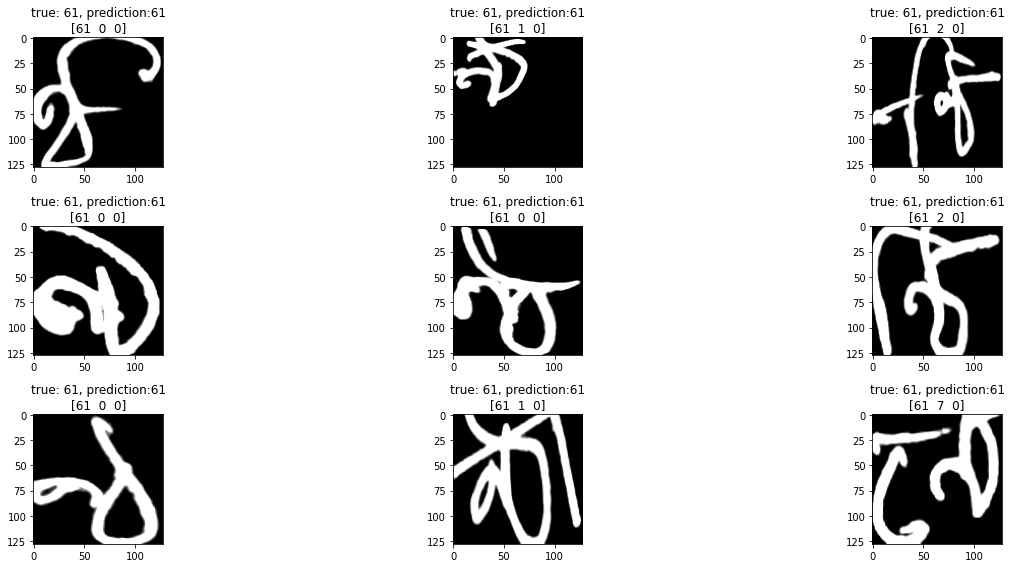



0it [00:00, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
9it [00:00, 126.57it/s]


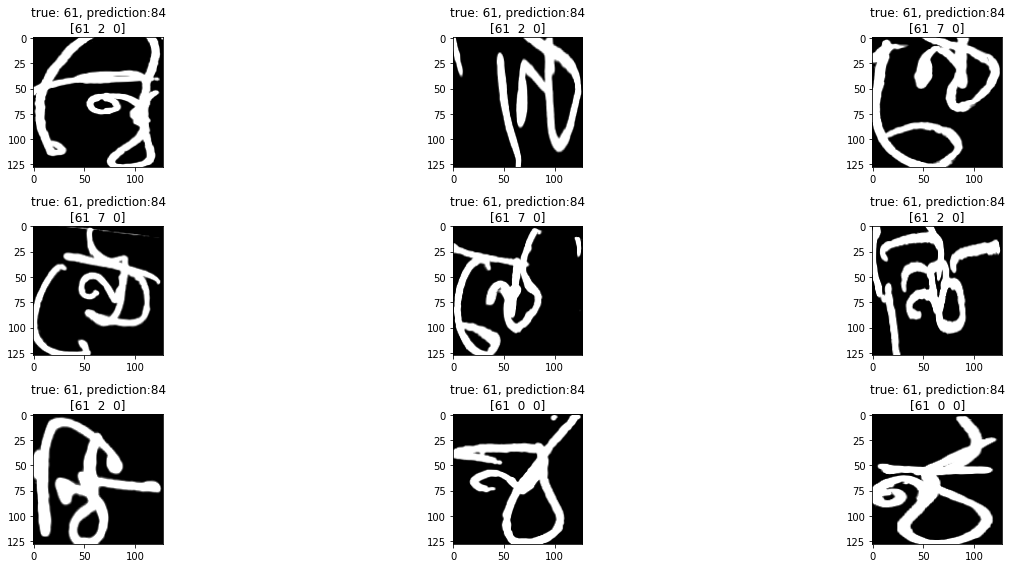

In [718]:
from scipy.ndimage.measurements import label

label2 = 61

subset_df = combined_df[combined_df['true_label']==label2]
subset_df['correct'] = (subset_df['prediction']==subset_df['true_label'])
n_fig = 10
f_index = subset_df[subset_df['correct']==False].index[:n_fig]
t_index = subset_df[subset_df['correct']==True].index[:n_fig]

nrow, ncol = 3, 3

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    i = t_index[i]
    image, label2 = train_dataset[i]
    image = np.einsum('ijk->jki', image)
    ax.imshow(image, cmap='Greys')
    #ax.set_title(f'label: {label}')
    ax.set_title("true: " + str(combined_df.loc[i]['true_label'])+", prediction:" + str(combined_df.loc[i]['prediction'])+"\n"+str(label2))
plt.tight_layout()
plt.show()


nrow, ncol = 3, 3

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    i = f_index[i]
    image, label2 = train_dataset[i]
    image = np.einsum('ijk->jki', image)
    ax.imshow(image, cmap='Greys')
    #ax.set_title(f'label: {label}')
    ax.set_title("true: " + str(combined_df.loc[i]['true_label'])+", prediction:" + str(combined_df.loc[i]['prediction'])+"\n"+str(label2))
plt.tight_layout()
plt.show()


0it [00:00, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for in

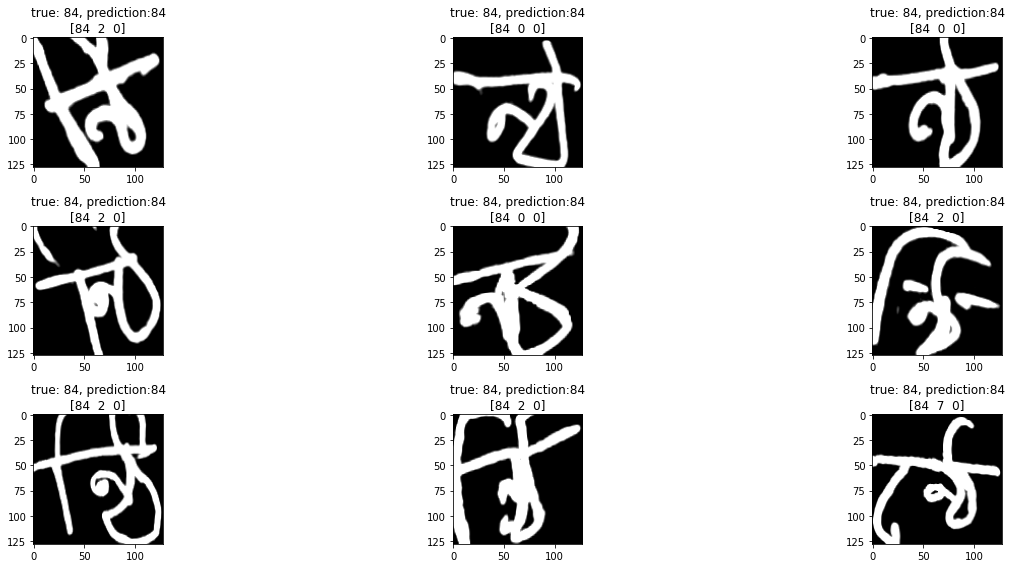


0it [00:00, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
0it [00:00, ?it/s]


IndexError: index 7 is out of bounds for axis 0 with size 7

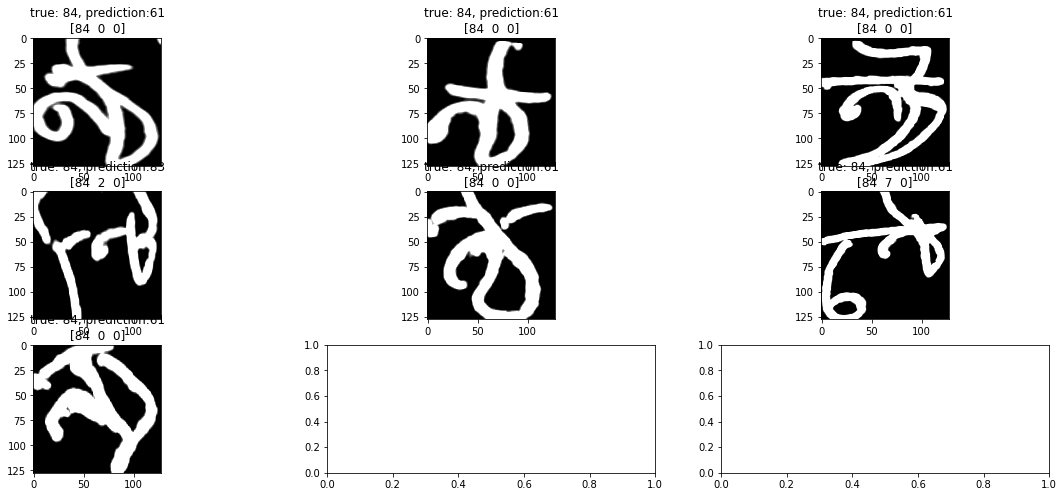

In [186]:
label2 = 84

subset_df = combined_df[combined_df['true_label']==label2]

n_fig = 10
f_index = subset_df[subset_df['correct']==False].index[:n_fig]
t_index = subset_df[subset_df['correct']==True].index[:n_fig]

nrow, ncol = 3, 3

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    i = t_index[i]
    image, label2 = train_dataset[i]
    image = np.einsum('ijk->jki', image)
    ax.imshow(image, cmap='Greys')
    #ax.set_title(f'label: {label}')
    ax.set_title("true: " + str(combined_df.loc[i]['true_label'])+", prediction:" + str(combined_df.loc[i]['prediction'])+"\n"+str(label2))
plt.tight_layout()
plt.show()


nrow, ncol = 3, 3

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    i = f_index[i]
    image, label2 = train_dataset[i]
    image = np.einsum('ijk->jki', image)
    ax.imshow(image, cmap='Greys')
    #ax.set_title(f'label: {label}')
    ax.set_title("true: " + str(combined_df.loc[i]['true_label'])+", prediction:" + str(combined_df.loc[i]['prediction'])+"\n"+str(label2))
plt.tight_layout()
plt.show()

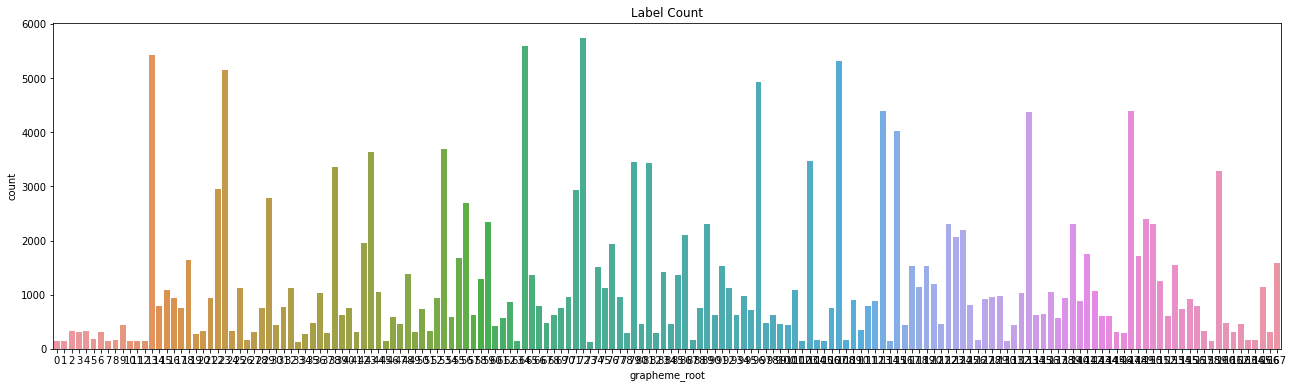

In [187]:
fig, axes = plt.subplots(1, 1, figsize=(22, 6))
plt.title('Label Count')
sns.countplot(x="grapheme_root",data=train)


0it [00:00, ?it/s]


TypeError: 'numpy.ndarray' object is not callable

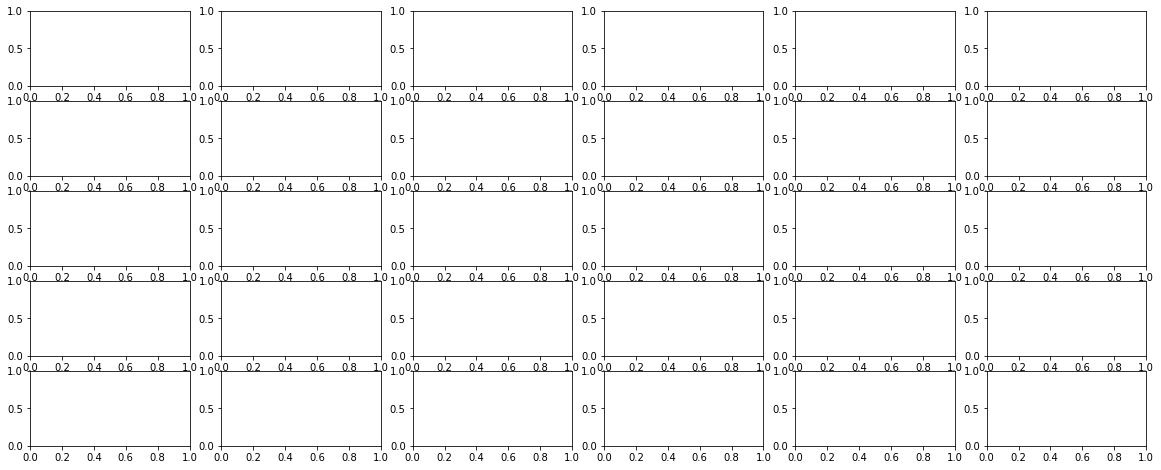

In [192]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label2 = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label2}')
plt.tight_layout()
plt.show()

<a id="ref"></a>
# Reference and further reading

#### Kernel

**[Bangali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bangali-ai-super-fast-data-loading-with-feather)**<br>
Simple example of how use feather format data to load data faster.

**[Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)**<br>
Tutorial for Data augmentations with albumentations library.

**[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)**<br>
**Prediction code of this kernel's trained model, please check this too!**

**[Deep learning - CNN with Chainer: LB 0.99700](https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700)**<br>
Data augmentation idea is based on this kernel, which achieves quite high accuracy on MNIST task.

#### Dataset
**[bengaliai-cv19-feather](https://www.kaggle.com/corochann/bengaliaicv19feather)**<br>
Feather format dataset

**[bengaliaicv19_seresnext101_32x4d](https://www.kaggle.com/corochann/bengaliaicv19-seresnext101-32x4d)**<br>
**Trained model weight with this kernel(v1)**

**[bengaliaicv19_trainedmodels](https://www.kaggle.com/corochann/bengaliaicv19-trainedmodels)**<br>
**Trained model weight with this kernel(v2~)**

#### Library
**https://github.com/pytorch/ignite**

Used for training code abstraction. The advantage of abstracting the code is that we can re-use implemented handler class for other training, other competition.<br>
You don't need to write code for saving models, logging training loss/metric, show progressbar etc.

**https://github.com/Cadene/pretrained-models.pytorch**

Many pretrained models are supported by this library, and we can switch to use them easily.
Other model may perform better in this competition.

**https://github.com/albumentations-team/albumentations**

fast image augmentation library and easy to use wrapper around other libraries https://arxiv.org/abs/1809.06839<br>
I could not show all the methods, you can find more methods in the library, check yourself!

<h3 style="color:red">If this kernel helps you, please upvote to keep me motivated :)<br>Thanks!</h3>